#  De belles cartes avec python: mise en pratique



<a href="https://github.com/linogaliana/python-datascientist/blob/master//__w/python-datascientist/python-datascientist/notebooks/course/visualisation/maps.ipynb" class="github"><i class="fab fa-github"></i></a>
[![Download](https://img.shields.io/badge/Download-Notebook-important?logo=Jupyter)](https://downgit.github.io/#/home?url=https://github.com/linogaliana/python-datascientist/blob/master//__w/python-datascientist/python-datascientist/notebooks/course/visualisation/maps.ipynb)
[![nbviewer](https://img.shields.io/badge/Visualize-nbviewer-blue?logo=Jupyter)](https://nbviewer.jupyter.org/github/linogaliana/python-datascientist/blob/master//__w/python-datascientist/python-datascientist/notebooks/course/visualisation/maps.ipynb)
[![Onyxia](https://img.shields.io/badge/SSPcloud-Tester%20via%20SSP--cloud-informational&color=yellow?logo=Python)](https://datalab.sspcloud.fr/launcher/inseefrlab-helm-charts-datascience/jupyter?onyxia.friendlyName=«python-datascientist»&resources.requests.memory=«4Gi»&security.allowlist.enabled=false&init.personalInit=«https://raw.githubusercontent.com/linogaliana/python-datascientist/master/init_onyxia.sh»)
[![Binder](https://img.shields.io/badge/Launch-Binder-E66581.svg?logo=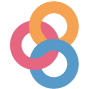)](https://mybinder.org/v2/gh/linogaliana/python-datascientist/master?filepath=/__w/python-datascientist/python-datascientist/notebooks/course/visualisation/maps.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](http://colab.research.google.com/github/linogaliana/python-datascientist/blob/master//__w/python-datascientist/python-datascientist/notebooks/course/visualisation/maps.ipynb)
[![githubdev](https://open.vscode.dev/badges/open-in-vscode.svg)](https://github.dev/linogaliana/python-datascientist//__w/python-datascientist/python-datascientist/notebooks/course/visualisation/maps.ipynb)

La pratique de la cartographie se fera, dans ce cours, en répliquant des cartes qu'on peut trouver sur
la page de l'*open-data* de la ville de Paris 
[ici](https://opendata.paris.fr/explore/dataset/comptage-velo-donnees-compteurs/information/?disjunctive.id_compteur&disjunctive.nom_compteur&disjunctive.id&disjunctive.name).

Produire de belles cartes demande du temps mais aussi du bon sens. En fonction de la structure des données, certaines représentations sont à éviter voire à exclure. L'excellent guide [disponible ici](https://juliedjidji.github.io/memocarto/semio.html) propose quelques règles et évoque les erreurs à éviter lorsqu'on désire effectuer des
représentations spatiales. 


Ce TP vise à initier:

* Au module graphique de [geopandas](https://geopandas.org/mapping.html) ainsi qu'aux packages [geoplot](https://residentmario.github.io/geoplot/index.html) et
[contextily](https://contextily.readthedocs.io/en/latest/intro_guide.html) pour la construction de cartes figées. `geoplot` est construit sur `seaborn` et constitue ainsi une extension des graphiques de base.
* Au package [folium](https://python-visualization.github.io/folium/) qui est un point d'accès vers la librairie JavaScript [leaflet](https://leafletjs.com/) permettant de produire des cartes interactives

Les données utilisées sont :

* Un sous-ensemble des données de [paris open data](https://opendata.paris.fr/explore/dataset/comptage-velo-donnees-compteurs/information/?disjunctive.id_compteur&disjunctive.nom_compteur&disjunctive.id&disjunctive.name) a été mis à disposition
sur {{< githubrepo >}} pour faciliter l'import (élimination des colonnes
qui ne nous servirons pas mais ralentissent l'import)
* [La localisation précise des stations](https://parisdata.opendatasoft.com/explore/dataset/comptage-velo-compteurs/download/?format=geojson&timezone=Europe/Berlin&lang=fr)
* [Arrondissements parisiens](https://opendata.paris.fr/explore/dataset/arrondissements/download/?format=geojson&timezone=Europe/Berlin&lang=fr)

Dans la première partie, nous allons utiliser les packages suivants:


In [ ]:
import pandas as pd
import geopandas as gpd
import contextily as ctx
import geoplot
import matplotlib.pyplot as plt
import folium

Certaines librairies géographiques dépendent de `rtree` qui est parfois difficile à installer. Pour installer `rtree`, le mieux est d'utiliser `anaconda`.

Installations préalables : 


In [ ]:
# Sur anaconda
conda install rtree --yes

In [ ]:
# Sur colab
!pip install pandas fiona shapely pyproj rtree # à faire obligatoirement en premier pour utiliser rtree ou pygeos pour les jointures spatiales
!pip install contextily
!pip install geopandas
!pip install geoplot

## Première carte avec l'API `matplotlib` de `geopandas`

{{% panel status="exercise" title="Exercice"
icon="fas fa-pencil-alt" %}}

**Exercice 1: Importer les données**

Importer les données de compteurs de vélos en deux temps.

1. D'abord, les comptages peuvent être trouvés à l'adresse <https://github.com/linogaliana/python-datascientist/raw/master/data/bike.csv>. :warning: Il s'agit de données
compressées au format `gzip`, il faut donc utiliser l'option `compression`. Nommer cet objet `comptages`.



2. Importer les données de localisation des compteurs à partir de l'url <https://parisdata.opendatasoft.com/explore/dataset/comptage-velo-compteurs/download/?format=geojson&timezone=Europe/Berlin&lang=fr>. Nommer cet objet `compteurs`.


3. On va également utiliser les données d'arrondissements de la ville de Paris. Importer ces données depuis <https://opendata.paris.fr/explore/dataset/arrondissements/download/?format=geojson&timezone=Europe/Berlin&lang=fr>. Nommer cet objet `arrondissements`.



4. Utiliser la méthode `plot` pour représenter les localisations des compteurs dans l'espace. C'est, on peut l'avouer, peu informatif sans apport extérieur. Il va donc falloir travailler un peu l'esthétique



On serait tenté de faire un *merge* de la base compteurs et comptages. En l'occurrence, il s'agirait d'un produit cartésien puisqu'il s'agit de faire exploser la base spatiale. Avec des données spatiales, c'est souvent une très mauvaise idée. Cela duplique les points, créant des difficultés à représenter les données mais aussi ralentit les calculs. Sauf à utiliser la méthode `dissolve` (qui va agréger *k* fois la même géométrie...), les géométries sont perdues lorsqu'on effectue des `groupby`.  



Maintenant, tout est prêt pour une première carte. `matplotlib` fonctionne selon
le principe des couches. On va de la couche la plus lointaine à celle le plus
en surface. L'exception est lorsqu'on ajoute un fond de carte `contextily` via
`ctx.add_basemap`: on met cet appel en dernier. 

{{% panel status="exercise" title="Exercice"
icon="fas fa-pencil-alt" %}}

**Exercice 2: Première carte**

Représenter une carte des `compteurs` avec le fonds de carte des `arrondissements`

  * Faire attention à avoir des arrondissements dont l'intérieur est transparent (argument à utiliser: `facecolor`).
  * Faire des bordures d'arrondissements noires et affichez les compteurs en rouge.
  * Pour obtenir un graphique plus grand, vous pouvez utiliser l'argument `figsize = (10,10)`.
  * Pour les localisations, les points doivent être rouges en étant plus transparent au centre (argument à utiliser: `alpha`) 



Vous devriez obtenir cette carte:




{{% panel status="exercise" title="Exercice"
icon="fas fa-pencil-alt" %}}

**Exercice 3 : Ajouter un fonds de carte avec contextily**

Repartir de la carte précédente.

1. Utiliser `ctx.add_basemap` pour ajouter un fonds de carte. Pour ne pas afficher les axes, vous pouvez utiliser `ax.set_axis_off()`.

:warning: *Par défaut, `contextily` désire un système de projection (crs) qui est le Web Mercator (epsg: 3857). Il faut changer la valeur de l'argument `crs`.*

:warning: *Avec les versions anciennes des packages, il faut utiliser `.to_string` sur un objet CRS pour qu'il soit reconnu par `contextily`. Sur des versions récentes, la valeur numérique du code EPSG est suffisante.*




2. Trouver un fonds de carte plus esthétique, qui permette de visualiser les grands axes, parmi ceux possibles. Pour tester l'esthétique, vous pouvez utiliser [cet url](http://leaflet-extras.github.io/leaflet-providers/preview/index.html). La documentation de référence sur les tuiles disponibles est [ici](https://contextily.readthedocs.io/en/latest/providers_deepdive.html) 


Le principe de la *heatmap* est de construire, à partir d'un nuage de point bidimensionnel, une distribution 2D lissée. La méthode repose sur les estimateurs à noyaux qui sont des méthodes de lissage local. 


Pour le moment, la fonction  `geoplot.kdeplot` n'incorpore pas toutes les fonctionalités de `seaborn.kdeplot`. Pour être en mesure de construire une `heatmap` avec des données pondérées (cf. [cette issue dans le dépôt seaborn](https://github.com/mwaskom/seaborn/issues/1364)), il y a une astuce. Il faut simuler *k* points de valeur 1 autour de la localisation observée. La fonction ci-dessous, qui m'a été bien utile, est pratique


In [ ]:
import numpy as np
def expand_points(shapefile,
                  index_var = "grid_id",
                  weight_var = 'prop',
                  radius_sd = 100,
                  crs = 2154):
    """
    Multiply number of points to be able to have a weighted heatmap
    :param shapefile: Shapefile to consider
    :param index_var: Variable name to set index
    :param weight_var: Variable that should be used
    :param radius_sd: Standard deviation for the radius of the jitter
    :param crs: Projection system that should be used. Recommended option
      is Lambert 93 because points will be jitterized using meters
    :return:
      A geopandas point object with as many points by index as weight
    """

    shpcopy = shapefile
    shpcopy = shpcopy.set_index(index_var)
    shpcopy['npoints'] = np.ceil(shpcopy[weight_var])
    shpcopy['geometry'] = shpcopy['geometry'].centroid
    shpcopy['x'] = shpcopy.geometry.x
    shpcopy['y'] = shpcopy.geometry.y
    shpcopy = shpcopy.to_crs(crs)
    shpcopy = shpcopy.loc[np.repeat(shpcopy.index.values, shpcopy.npoints)]
    shpcopy['x'] = shpcopy['x'] + np.random.normal(0, radius_sd, shpcopy.shape[0])
    shpcopy['y'] = shpcopy['y'] + np.random.normal(0, radius_sd, shpcopy.shape[0])

    gdf = gpd.GeoDataFrame(
        shpcopy,
        geometry = gpd.points_from_xy(shpcopy.x, shpcopy.y),
        crs = crs)

    return gdf

{{% panel status="exercise" title="Exercice"
icon="fas fa-pencil-alt" %}}

**Exercice 4 : Data cleaning avant de pouvoir faire une heatmap**

1. Calculer le trafic moyen, pour chaque station, entre 7 heures et 10 heures (bornes incluses) et nommer cet objet `df1`. Faire la même chose, en nommant `df2`, pour le trafic entre 17 et 20 heures (bornes incluses)



2. Nous allons désormais préparer les données de manière à faire une heatmap. Après avoir compris ce que permet de faire la fonction `expand_points` ci-dessus, créer une fonction `explode_data` qui suive les étapes suivantes. 
  + Convertir un DataFrame dans le système de projection Lambert 93 (epsg: 2154)
  + Appliquer `expand_points` aux noms de variable adéquats. Vous pouvez fixer la valeur de `radius_sd` à `100`. 
  + Reconvertir l'output au format WGS84 (epsg: 4326)



3. Appliquer cette fonction à `df1` et `df2`





**Exercice 5 : Heatmap, enfin !**

Représenter, pour ces deux moments de la journée, la `heatmap` du trafic de vélo avec `geoplot.kdeplot`. Pour cela :

- Appliquer la fonction `geoplot.kdeplot` avec comme consignes :
    + d'utiliser les arguments `shade=True` et `shade_lowest=True` pour colorer l'intérieur des courbes de niveaux obtenues ; 
    + d'utiliser une palette de couleur rouge avec une transparence modérée (`alpha = 0.6`)
    + d'utiliser l'argument `clip` pour ne pas déborder hors de Paris (en cas de doute, se référer à l'aide de `geoplot.kdeplot`)
    + L'argument `bw` (pour *bandwidth*) détermine le plus ou moins fort lissage spatial. Vous pouvez partir d'un bandwidth égal à 0.01 et le faire varier pour voir l'effet sur le résultat 
    
- Ne pas oublier d'ajouter les arrondissements. Avec `geoplot`, il faut utiliser `geoplot.polyplot`. 







## Des cartes réactives grâce à `folium`

De plus en plus de données de visualisation reposent sur la cartographie réactive. Que ce soit dans l'exploration des données ou dans la représentation finale de résultats, la cartographie réactive est très appréciable. 

`folium` offre une interface très flexible et très facile à prendre à main. Les cartes sont construites grâce à la librairie JavaScript `Leaflet.js` mais, sauf si on désire aller loin dans la customisation du résultat, il n'est pas nécessaire d'avoir des notions dans le domaine. 

Un objet folium se construit par couche. La première est l'initialisation de la carte. Les couches suivantes sont les éléments à mettre en valeur. L'initialisation de la carte nécessite la définition d'un point central (paramètre `location`) et d'un zoom de départ (`zoom_start`). Plutôt que de fournir manuellement le point central et le zoom on peut :

1. Déterminer le point central en construisant des colonnes longitudes et latitudes et en prenant la moyenne de celles-ci ;
2. Utiliser la méthode `fit_bounds` qui cale la carte sur les coins sud-ouest et nord-est. En supposant que la carte s'appelle `m`, on fera `m.fit_bounds([sw, ne])`

Le bout de code suivant permet de calculer le centre de la carte


In [ ]:
compteurs['lon'] = compteurs.geometry.x
compteurs['lat'] = compteurs.geometry.y
center = compteurs[['lat', 'lon']].mean().values.tolist()
print(center)

```
## [48.856288029999995, 2.34339106]
```

Alors que le code suivant permet de calculer les coins:


In [ ]:
sw = compteurs[['lat', 'lon']].min().values.tolist()
ne = compteurs[['lat', 'lon']].max().values.tolist()
print(sw)

```
## [48.82024, 2.26542]
```

In [ ]:
print(ne)

```
## [48.89696, 2.40969]
```

Si un fond gris s'affiche, c'est qu'il y a un problème de localisation. Cela provient généralement d'un problème de projection ou d'une inversion des longitudes et latitudes. 

Les longitudes représentent les *x* (axe ouest-est) et les latitudes *y* (axe sud-nord). De manière contrintuitive, `folium` attend qu'on lui fournisse les données sous la forme `[latitude, longitude]` donc `[y,x]`


**Exercice 6 : Visualiser la localisation des stations**

1. Calculer le centre `center`de la carte des données `compteurs`. Il s'obtient en agrègeant l'ensemble des géométries, calculant le centroid et récupèrant la valeur sous forme de liste. Avec une logique similaire, calculez les bornes du sud-ouest `sw` et du nord-est `ne` de la carte. 


2. Représenter la localisation des stations en utilisant un zoom optimal. 





La carte obtenue doit ressembler à la suivante:

<div style="width:100%;"><div style="position:relative;width:100%;height:0;padding-bottom:60%;"><span style="color:#565656">Make this Notebook Trusted to load map: File -> Trust Notebook</span><iframe src="about:blank" style="position:absolute;width:100%;height:100%;left:0;top:0;border:none !important;" data-html=%3C%21DOCTYPE%20html%3E%0A%3Chead%3E%20%20%20%20%0A%20%20%20%20%3Cmeta%20http-equiv%3D%22content-type%22%20content%3D%22text/html%3B%20charset%3DUTF-8%22%20/%3E%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%3Cscript%3E%0A%20%20%20%20%20%20%20%20%20%20%20%20L_NO_TOUCH%20%3D%20false%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20L_DISABLE_3D%20%3D%20false%3B%0A%20%20%20%20%20%20%20%20%3C/script%3E%0A%20%20%20%20%0A%20%20%20%20%3Cstyle%3Ehtml%2C%20body%20%7Bwidth%3A%20100%25%3Bheight%3A%20100%25%3Bmargin%3A%200%3Bpadding%3A%200%3B%7D%3C/style%3E%0A%20%20%20%20%3Cstyle%3E%23map%20%7Bposition%3Aabsolute%3Btop%3A0%3Bbottom%3A0%3Bright%3A0%3Bleft%3A0%3B%7D%3C/style%3E%0A%20%20%20%20%3Cscript%20src%3D%22https%3A//cdn.jsdelivr.net/npm/leaflet%401.6.0/dist/leaflet.js%22%3E%3C/script%3E%0A%20%20%20%20%3Cscript%20src%3D%22https%3A//code.jquery.com/jquery-1.12.4.min.js%22%3E%3C/script%3E%0A%20%20%20%20%3Cscript%20src%3D%22https%3A//maxcdn.bootstrapcdn.com/bootstrap/3.2.0/js/bootstrap.min.js%22%3E%3C/script%3E%0A%20%20%20%20%3Cscript%20src%3D%22https%3A//cdnjs.cloudflare.com/ajax/libs/Leaflet.awesome-markers/2.0.2/leaflet.awesome-markers.js%22%3E%3C/script%3E%0A%20%20%20%20%3Clink%20rel%3D%22stylesheet%22%20href%3D%22https%3A//cdn.jsdelivr.net/npm/leaflet%401.6.0/dist/leaflet.css%22/%3E%0A%20%20%20%20%3Clink%20rel%3D%22stylesheet%22%20href%3D%22https%3A//maxcdn.bootstrapcdn.com/bootstrap/3.2.0/css/bootstrap.min.css%22/%3E%0A%20%20%20%20%3Clink%20rel%3D%22stylesheet%22%20href%3D%22https%3A//maxcdn.bootstrapcdn.com/bootstrap/3.2.0/css/bootstrap-theme.min.css%22/%3E%0A%20%20%20%20%3Clink%20rel%3D%22stylesheet%22%20href%3D%22https%3A//maxcdn.bootstrapcdn.com/font-awesome/4.6.3/css/font-awesome.min.css%22/%3E%0A%20%20%20%20%3Clink%20rel%3D%22stylesheet%22%20href%3D%22https%3A//cdnjs.cloudflare.com/ajax/libs/Leaflet.awesome-markers/2.0.2/leaflet.awesome-markers.css%22/%3E%0A%20%20%20%20%3Clink%20rel%3D%22stylesheet%22%20href%3D%22https%3A//cdn.jsdelivr.net/gh/python-visualization/folium/folium/templates/leaflet.awesome.rotate.min.css%22/%3E%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cmeta%20name%3D%22viewport%22%20content%3D%22width%3Ddevice-width%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20initial-scale%3D1.0%2C%20maximum-scale%3D1.0%2C%20user-scalable%3Dno%22%20/%3E%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cstyle%3E%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%23map_df129aea393c48e19b8057a8ce932d76%20%7B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20position%3A%20relative%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20width%3A%20100.0%25%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20height%3A%20100.0%25%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20left%3A%200.0%25%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20top%3A%200.0%25%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3C/style%3E%0A%20%20%20%20%20%20%20%20%0A%3C/head%3E%0A%3Cbody%3E%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cdiv%20class%3D%22folium-map%22%20id%3D%22map_df129aea393c48e19b8057a8ce932d76%22%20%3E%3C/div%3E%0A%20%20%20%20%20%20%20%20%0A%3C/body%3E%0A%3Cscript%3E%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20map_df129aea393c48e19b8057a8ce932d76%20%3D%20L.map%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%22map_df129aea393c48e19b8057a8ce932d76%22%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20center%3A%20%5B48.856288029999995%2C%202.34339106%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20crs%3A%20L.CRS.EPSG3857%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20zoom%3A%2010%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20zoomControl%3A%20true%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20preferCanvas%3A%20false%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29%3B%0A%0A%20%20%20%20%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20tile_layer_f689be03123c4b25af866c401cf5f10b%20%3D%20L.tileLayer%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%22https%3A//stamen-tiles-%7Bs%7D.a.ssl.fastly.net/toner/%7Bz%7D/%7Bx%7D/%7By%7D.png%22%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22attribution%22%3A%20%22Map%20tiles%20by%20%5Cu003ca%20href%3D%5C%22http%3A//stamen.com%5C%22%5Cu003eStamen%20Design%5Cu003c/a%5Cu003e%2C%20under%20%5Cu003ca%20href%3D%5C%22http%3A//creativecommons.org/licenses/by/3.0%5C%22%5Cu003eCC%20BY%203.0%5Cu003c/a%5Cu003e.%20Data%20by%20%5Cu0026copy%3B%20%5Cu003ca%20href%3D%5C%22http%3A//openstreetmap.org%5C%22%5Cu003eOpenStreetMap%5Cu003c/a%5Cu003e%2C%20under%20%5Cu003ca%20href%3D%5C%22http%3A//www.openstreetmap.org/copyright%5C%22%5Cu003eODbL%5Cu003c/a%5Cu003e.%22%2C%20%22detectRetina%22%3A%20false%2C%20%22maxNativeZoom%22%3A%2018%2C%20%22maxZoom%22%3A%2018%2C%20%22minZoom%22%3A%200%2C%20%22noWrap%22%3A%20false%2C%20%22opacity%22%3A%201%2C%20%22subdomains%22%3A%20%22abc%22%2C%20%22tms%22%3A%20false%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_8ffee4cb684f48218d57a435575b0af2%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.846099%2C%202.375456%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_d935516bea7d4ff990a86dec5ec97ce0%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_36801ca922614575b6e22df7d7a6982b%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_36801ca922614575b6e22df7d7a6982b%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E27%20boulevard%20Diderot%20E-O%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_d935516bea7d4ff990a86dec5ec97ce0.setContent%28html_36801ca922614575b6e22df7d7a6982b%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_8ffee4cb684f48218d57a435575b0af2.bindPopup%28popup_d935516bea7d4ff990a86dec5ec97ce0%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_130d74803ffe4e878c613f779d8b9276%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.84015%2C%202.26733%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_5c3a66b5ebc54ad698c5805d8096bcee%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_139f9985dafc4c71948b15e9bd25c3e8%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_139f9985dafc4c71948b15e9bd25c3e8%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20du%20Garigliano%20NO-SE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_5c3a66b5ebc54ad698c5805d8096bcee.setContent%28html_139f9985dafc4c71948b15e9bd25c3e8%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_130d74803ffe4e878c613f779d8b9276.bindPopup%28popup_5c3a66b5ebc54ad698c5805d8096bcee%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_dbae928fcf964bdfa7d640eeb4590e35%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.889046%2C%202.374872%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_68d5a0035f5b4154a8d1e26c9854428e%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_32d655d997c54e79add7f609d3e94da2%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_32d655d997c54e79add7f609d3e94da2%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E72%20avenue%20de%20Flandre%20SO-NE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_68d5a0035f5b4154a8d1e26c9854428e.setContent%28html_32d655d997c54e79add7f609d3e94da2%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_dbae928fcf964bdfa7d640eeb4590e35.bindPopup%28popup_68d5a0035f5b4154a8d1e26c9854428e%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_12732773d3204957a252a31aae336fb5%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86377%2C%202.35096%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_46ba714e40854c61a380315a19bc01e1%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_d7d58bba6ac24f528b041c03edb3dd36%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_d7d58bba6ac24f528b041c03edb3dd36%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3ETotem%2073%20boulevard%20de%20S%C3%A9bastopol%20N-S%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_46ba714e40854c61a380315a19bc01e1.setContent%28html_d7d58bba6ac24f528b041c03edb3dd36%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_12732773d3204957a252a31aae336fb5.bindPopup%28popup_46ba714e40854c61a380315a19bc01e1%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_8f1fdd9ab3984a71871c8ebca0fdf826%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83521%2C%202.33307%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_ee3187c195014987a0bcf1a1eab2ea70%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_69261bda00a34d24928cecb8f2e8bf97%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_69261bda00a34d24928cecb8f2e8bf97%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E106%20avenue%20Denfert%20Rochereau%20NE-SO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_ee3187c195014987a0bcf1a1eab2ea70.setContent%28html_69261bda00a34d24928cecb8f2e8bf97%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_8f1fdd9ab3984a71871c8ebca0fdf826.bindPopup%28popup_ee3187c195014987a0bcf1a1eab2ea70%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_6392c24c98d841d7ae90a3e9ec8838f3%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.8484%2C%202.27586%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_ad89525a740a4a40baa17f994cf97a88%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_7b293f1504e547f2a9f0b3b419b275ce%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_7b293f1504e547f2a9f0b3b419b275ce%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EVoie%20Georges%20Pompidou%20NE-SO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_ad89525a740a4a40baa17f994cf97a88.setContent%28html_7b293f1504e547f2a9f0b3b419b275ce%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_6392c24c98d841d7ae90a3e9ec8838f3.bindPopup%28popup_ad89525a740a4a40baa17f994cf97a88%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_68a0da94f689437f871d3269a0615bcf%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86357%2C%202.32203%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_503eb40b91ce4a1dbd047df9d49e937e%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_4507d11ca48648e196b9f0a459bac0f6%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_4507d11ca48648e196b9f0a459bac0f6%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EQuai%20des%20Tuileries%20NO-SE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_503eb40b91ce4a1dbd047df9d49e937e.setContent%28html_4507d11ca48648e196b9f0a459bac0f6%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_68a0da94f689437f871d3269a0615bcf.bindPopup%28popup_503eb40b91ce4a1dbd047df9d49e937e%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_60be4b8428ee48f7bb3621b756e22e3c%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.842091%2C%202.301%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_7bc4089043a94a14a4f89f06dcc0f463%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_0e8f55b3778741a2b14fdcb7af93a09a%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_0e8f55b3778741a2b14fdcb7af93a09a%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E129%20rue%20Lecourbe%20SO-NE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_7bc4089043a94a14a4f89f06dcc0f463.setContent%28html_0e8f55b3778741a2b14fdcb7af93a09a%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_60be4b8428ee48f7bb3621b756e22e3c.bindPopup%28popup_7bc4089043a94a14a4f89f06dcc0f463%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_fa48583a7853404880c9fdf1b1937c4a%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.84638%2C%202.31529%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_dbe3e49c95b4428fab1c1f4ea700b5c1%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_74203bfdef994d7bbc141e19f1834f60%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_74203bfdef994d7bbc141e19f1834f60%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E90%20Rue%20De%20S%C3%A8vres%20SO-NE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_dbe3e49c95b4428fab1c1f4ea700b5c1.setContent%28html_74203bfdef994d7bbc141e19f1834f60%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_fa48583a7853404880c9fdf1b1937c4a.bindPopup%28popup_dbe3e49c95b4428fab1c1f4ea700b5c1%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_cf3d79dc7f324a0abbdb90ec4b74e125%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.85372%2C%202.35702%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_6821956e2b304ad78ecf507227143274%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_7c26a236e47b4b0fb76dcf25d19d29c5%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_7c26a236e47b4b0fb76dcf25d19d29c5%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E18%20quai%20de%20l%27H%C3%B4tel%20de%20Ville%20SE-NO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_6821956e2b304ad78ecf507227143274.setContent%28html_7c26a236e47b4b0fb76dcf25d19d29c5%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_cf3d79dc7f324a0abbdb90ec4b74e125.bindPopup%28popup_6821956e2b304ad78ecf507227143274%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_eee207db5b4f42aabc488faad99d1819%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86149%2C%202.37376%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_e6dc52a88a4241e39b1efc7c2f87a9bc%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_1d77480803e342fb8828f3a55cbb16ef%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_1d77480803e342fb8828f3a55cbb16ef%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E67%20boulevard%20Voltaire%20SE-NO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_e6dc52a88a4241e39b1efc7c2f87a9bc.setContent%28html_1d77480803e342fb8828f3a55cbb16ef%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_eee207db5b4f42aabc488faad99d1819.bindPopup%28popup_e6dc52a88a4241e39b1efc7c2f87a9bc%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_365dcbbdebf6478aa4c796ca89d870df%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.830449%2C%202.353199%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_f79f6d0a9c5f47559a3432a5f10b9fd1%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_f8cfa0cb2c9a445989a1d22c398c3a2a%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_f8cfa0cb2c9a445989a1d22c398c3a2a%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E21%20boulevard%20Auguste%20Blanqui%20SO-NE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_f79f6d0a9c5f47559a3432a5f10b9fd1.setContent%28html_f8cfa0cb2c9a445989a1d22c398c3a2a%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_365dcbbdebf6478aa4c796ca89d870df.bindPopup%28popup_f79f6d0a9c5f47559a3432a5f10b9fd1%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_cde727b2cb88499c81bf506d547c8c10%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.840801%2C%202.333233%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_fc3c959c4e74499087018a32fa9434fb%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_6261766476e64f9eb89263396ecdcbc4%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_6261766476e64f9eb89263396ecdcbc4%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E152%20boulevard%20du%20Montparnasse%20O-E%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_fc3c959c4e74499087018a32fa9434fb.setContent%28html_6261766476e64f9eb89263396ecdcbc4%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_cde727b2cb88499c81bf506d547c8c10.bindPopup%28popup_fc3c959c4e74499087018a32fa9434fb%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_3f92e0c1f610464498d4fcf56b24fea8%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.89696%2C%202.34538%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_2e362cc4a1144027856dff50f6bcef4b%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_0bdfaacc93a04a37a9e9343d89f584a4%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_0bdfaacc93a04a37a9e9343d89f584a4%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E69%20Boulevard%20Ornano%20N-S%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_2e362cc4a1144027856dff50f6bcef4b.setContent%28html_0bdfaacc93a04a37a9e9343d89f584a4%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_3f92e0c1f610464498d4fcf56b24fea8.bindPopup%28popup_2e362cc4a1144027856dff50f6bcef4b%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_ff6bd3916ab948689769e161abc59772%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.85372%2C%202.35702%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_45832f25639048a58a0b08022fb9736d%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_39ea1d4987804b98b7d3cca34c9d6a7e%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_39ea1d4987804b98b7d3cca34c9d6a7e%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E18%20quai%20de%20l%27H%C3%B4tel%20de%20Ville%20NO-SE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_45832f25639048a58a0b08022fb9736d.setContent%28html_39ea1d4987804b98b7d3cca34c9d6a7e%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_ff6bd3916ab948689769e161abc59772.bindPopup%28popup_45832f25639048a58a0b08022fb9736d%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_fc3b1d224b034301af64bb3d23ab69dd%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86179%2C%202.32014%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_869a202506f94c51a1560303a8879ce6%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_844fb51c5d6943a081409bfb1a486c5d%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_844fb51c5d6943a081409bfb1a486c5d%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E243%20boulevard%20Saint%20Germain%20NO-SE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_869a202506f94c51a1560303a8879ce6.setContent%28html_844fb51c5d6943a081409bfb1a486c5d%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_fc3b1d224b034301af64bb3d23ab69dd.bindPopup%28popup_869a202506f94c51a1560303a8879ce6%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_190b3903891a4c88bc71685b6c4604cd%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.85735%2C%202.35211%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_7cf45df629f94f82b71ebc52b52a6d34%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_c6be610360454f63b4c28e3fe72f75fb%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_c6be610360454f63b4c28e3fe72f75fb%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3ETotem%2064%20Rue%20de%20Rivoli%20E-O%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_7cf45df629f94f82b71ebc52b52a6d34.setContent%28html_c6be610360454f63b4c28e3fe72f75fb%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_190b3903891a4c88bc71685b6c4604cd.bindPopup%28popup_7cf45df629f94f82b71ebc52b52a6d34%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_1b6295857bcd4be387e480b239c34437%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.88529%2C%202.32666%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_66d1fdd4df2349e29f95cffe91802d45%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_d6871fd3ddd641f3a3d0b4888a5817bb%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_d6871fd3ddd641f3a3d0b4888a5817bb%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E20%20Avenue%20de%20Clichy%20SE-NO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_66d1fdd4df2349e29f95cffe91802d45.setContent%28html_d6871fd3ddd641f3a3d0b4888a5817bb%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_1b6295857bcd4be387e480b239c34437.bindPopup%28popup_66d1fdd4df2349e29f95cffe91802d45%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_51a976751b8943dca3101c7f5abe3fcf%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.89172%2C%202.38531%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_12d16663f3c147e2895bef173c73b57a%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_bfca2c08f8ef4958858cc924e43fa27b%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_bfca2c08f8ef4958858cc924e43fa27b%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%2048%20quai%20de%20la%20marne%20NE-SO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_12d16663f3c147e2895bef173c73b57a.setContent%28html_bfca2c08f8ef4958858cc924e43fa27b%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_51a976751b8943dca3101c7f5abe3fcf.bindPopup%28popup_12d16663f3c147e2895bef173c73b57a%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_33a4053e6b8941feb996450328ea73d6%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.82682%2C%202.38465%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_53f58ea917844918af24ffa5b9313aca%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_ef7618658a5d45cda87bc3fcdaa2c593%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_ef7618658a5d45cda87bc3fcdaa2c593%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20National%20%20NE-SO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_53f58ea917844918af24ffa5b9313aca.setContent%28html_ef7618658a5d45cda87bc3fcdaa2c593%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_33a4053e6b8941feb996450328ea73d6.bindPopup%28popup_53f58ea917844918af24ffa5b9313aca%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_e889fc8cd90a421d9312b0928c01b5b2%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86357%2C%202.32203%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_60db005569da44ec9160468659e236da%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_bb0b0d9b169640718b96190f1ac56e18%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_bb0b0d9b169640718b96190f1ac56e18%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EQuai%20des%20Tuileries%20SE-NO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_60db005569da44ec9160468659e236da.setContent%28html_bb0b0d9b169640718b96190f1ac56e18%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_e889fc8cd90a421d9312b0928c01b5b2.bindPopup%28popup_60db005569da44ec9160468659e236da%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_c653d0e0bae644cda8d78f02bf0f2d9d%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.869831%2C%202.307076%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_fa95429337ed4367af0e0ca9a10a2d91%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_e409e1d7f6ee46469f39703fc2cce1bd%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_e409e1d7f6ee46469f39703fc2cce1bd%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E33%20avenue%20des%20Champs%20Elys%C3%A9es%20NO-SE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_fa95429337ed4367af0e0ca9a10a2d91.setContent%28html_e409e1d7f6ee46469f39703fc2cce1bd%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_c653d0e0bae644cda8d78f02bf0f2d9d.bindPopup%28popup_fa95429337ed4367af0e0ca9a10a2d91%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_1b4b775bb2904f839e101aa24f4ae7ae%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86282%2C%202.31061%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_a324806ff30b4ca0af8f409aa164e47c%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_28457f6ee00e4249abcd46699df7afc8%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_28457f6ee00e4249abcd46699df7afc8%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20des%20Invalides%20S-N%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_a324806ff30b4ca0af8f409aa164e47c.setContent%28html_28457f6ee00e4249abcd46699df7afc8%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_1b4b775bb2904f839e101aa24f4ae7ae.bindPopup%28popup_a324806ff30b4ca0af8f409aa164e47c%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_91e305e1f7914b64bfe8f0c6dde13991%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86155%2C%202.37407%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_3c6778ca9a9d474d8b619147f4045e93%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_8677054f52354e25a9b0f3e42edc0259%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_8677054f52354e25a9b0f3e42edc0259%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E72%20boulevard%20Voltaire%20NO-SE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_3c6778ca9a9d474d8b619147f4045e93.setContent%28html_8677054f52354e25a9b0f3e42edc0259%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_91e305e1f7914b64bfe8f0c6dde13991.bindPopup%28popup_3c6778ca9a9d474d8b619147f4045e93%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_bbf5cb6c242f443abfa19f765596f606%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86057%2C%202.38886%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_7b1f008c45914d9d9a3f617345550383%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_c3adaa3480eb4d679538578bc99aa510%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_c3adaa3480eb4d679538578bc99aa510%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E26%20boulevard%20de%20M%C3%A9nilmontant%20SE-NO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_7b1f008c45914d9d9a3f617345550383.setContent%28html_c3adaa3480eb4d679538578bc99aa510%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_bbf5cb6c242f443abfa19f765596f606.bindPopup%28popup_7b1f008c45914d9d9a3f617345550383%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_a9301ba0e6064bfbb1bb37c5369d57c8%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.829523%2C%202.38699%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_1add6fc5b2984e01ae29e5d5fbf2136d%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_c3eb5d82289a41e6a2a3212acc09c992%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_c3eb5d82289a41e6a2a3212acc09c992%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%2070%20quai%20de%20Bercy%20S-N%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_1add6fc5b2984e01ae29e5d5fbf2136d.setContent%28html_c3eb5d82289a41e6a2a3212acc09c992%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_a9301ba0e6064bfbb1bb37c5369d57c8.bindPopup%28popup_1add6fc5b2984e01ae29e5d5fbf2136d%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_6654b79ac2434db0ba676785d331d054%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.829523%2C%202.38699%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_9636797bb19d4eaea68b571ba7291ae7%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_c6d09a0f8a8d4945be6942c9682e1497%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_c6d09a0f8a8d4945be6942c9682e1497%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%2070%20quai%20de%20Bercy%20N-S%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_9636797bb19d4eaea68b571ba7291ae7.setContent%28html_c6d09a0f8a8d4945be6942c9682e1497%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_6654b79ac2434db0ba676785d331d054.bindPopup%28popup_9636797bb19d4eaea68b571ba7291ae7%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_a77cdc81e84448e9b0fc443471d5ebbe%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83848%2C%202.37587%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_b610db1ab7ec457cbb92d6eef69dbef7%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_d4f19bc56bb44182ad4750a5610e645d%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_d4f19bc56bb44182ad4750a5610e645d%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20de%20Bercy%20SO-NE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_b610db1ab7ec457cbb92d6eef69dbef7.setContent%28html_d4f19bc56bb44182ad4750a5610e645d%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_a77cdc81e84448e9b0fc443471d5ebbe.bindPopup%28popup_b610db1ab7ec457cbb92d6eef69dbef7%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_9e1633a86b5c46328b934c59ef55dd03%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86288%2C%202.31179%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_70807ca1aa7349f0ae57a194ceb4ec37%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_e438ca813b034cbd9724ce53a57abeb8%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_e438ca813b034cbd9724ce53a57abeb8%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EQuai%20d%27Orsay%20E-O%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_70807ca1aa7349f0ae57a194ceb4ec37.setContent%28html_e438ca813b034cbd9724ce53a57abeb8%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_9e1633a86b5c46328b934c59ef55dd03.bindPopup%28popup_70807ca1aa7349f0ae57a194ceb4ec37%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_b8a68520ed9d4af9be42669d999a2598%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.85013%2C%202.35423%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_6f9d10bf207346e69b3cd36bdabfe4b0%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_de718961f05347be83a61f9e194c1b99%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_de718961f05347be83a61f9e194c1b99%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E27%20quai%20de%20la%20Tournelle%20NO-SE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_6f9d10bf207346e69b3cd36bdabfe4b0.setContent%28html_de718961f05347be83a61f9e194c1b99%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_b8a68520ed9d4af9be42669d999a2598.bindPopup%28popup_6f9d10bf207346e69b3cd36bdabfe4b0%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_6ede971b55b34cc899a14df634fa608b%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83511%2C%202.33338%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_fd599bab55c54c15a8dba4f2e6b50999%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_da8dc6950f0440aabe049998e4e99545%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_da8dc6950f0440aabe049998e4e99545%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E97%20avenue%20Denfert%20Rochereau%20SO-NE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_fd599bab55c54c15a8dba4f2e6b50999.setContent%28html_da8dc6950f0440aabe049998e4e99545%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_6ede971b55b34cc899a14df634fa608b.bindPopup%28popup_fd599bab55c54c15a8dba4f2e6b50999%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_111a0657f10d4257a6179f7f9dded3f7%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.87451%2C%202.29215%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_3f0d881de9e84106a90ba222f9324b66%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_c3db688653164b4bbb938d0c77999f0c%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_c3db688653164b4bbb938d0c77999f0c%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E7%20avenue%20de%20la%20Grande%20Arm%C3%A9e%20NO-SE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_3f0d881de9e84106a90ba222f9324b66.setContent%28html_c3db688653164b4bbb938d0c77999f0c%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_111a0657f10d4257a6179f7f9dded3f7.bindPopup%28popup_3f0d881de9e84106a90ba222f9324b66%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_1e689fc339194fbabb63b14ade55682b%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.877726%2C%202.354926%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_f98971eb2fbe4b0fb0bf627a22fa2d61%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_df5e9284b27441f49d1be210419838d6%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_df5e9284b27441f49d1be210419838d6%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E102%20boulevard%20de%20Magenta%20SE-NO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_f98971eb2fbe4b0fb0bf627a22fa2d61.setContent%28html_df5e9284b27441f49d1be210419838d6%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_1e689fc339194fbabb63b14ade55682b.bindPopup%28popup_f98971eb2fbe4b0fb0bf627a22fa2d61%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_fa8654b22b6e4c2dacf3446d023f51d5%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.881626%2C%202.281203%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_db4741b578954650b335930691342586%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_dbc40d73c4594a0cbbeff6f6e791fba2%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_dbc40d73c4594a0cbbeff6f6e791fba2%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%2016%20avenue%20de%20la%20%20Porte%20des%20Ternes%20O-E%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_db4741b578954650b335930691342586.setContent%28html_dbc40d73c4594a0cbbeff6f6e791fba2%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_fa8654b22b6e4c2dacf3446d023f51d5.bindPopup%28popup_db4741b578954650b335930691342586%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_217ea7620218458cbbb4cbb23ee575cb%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.890457%2C%202.368852%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_9903f6ca390042509abb9a80597dc7e2%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_c77ceb587000442ab160fb535d355d97%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_c77ceb587000442ab160fb535d355d97%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20104%20rue%20d%27Aubervilliers%20S-N%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_9903f6ca390042509abb9a80597dc7e2.setContent%28html_c77ceb587000442ab160fb535d355d97%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_217ea7620218458cbbb4cbb23ee575cb.bindPopup%28popup_9903f6ca390042509abb9a80597dc7e2%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_3859ab4d80094806bd9635e221fdc1c7%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83992%2C%202.26694%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_0735034cf4704ea280e8fb6a12bed403%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_62e6a8574b704c53b858e06807672fc5%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_62e6a8574b704c53b858e06807672fc5%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20du%20Garigliano%20SE-NO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_0735034cf4704ea280e8fb6a12bed403.setContent%28html_62e6a8574b704c53b858e06807672fc5%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_3859ab4d80094806bd9635e221fdc1c7.bindPopup%28popup_0735034cf4704ea280e8fb6a12bed403%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_0f928ad60f4d40f4a10b9ae7f050cd7a%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86461%2C%202.40969%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_4a25855ab4034e1b9d303c84e2095ee6%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_1211c4403fce4a57a337fe587725536c%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_1211c4403fce4a57a337fe587725536c%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%204%20avenue%20de%20la%20porte%20de%20Bagnolet%20E-O%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_4a25855ab4034e1b9d303c84e2095ee6.setContent%28html_1211c4403fce4a57a337fe587725536c%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_0f928ad60f4d40f4a10b9ae7f050cd7a.bindPopup%28popup_4a25855ab4034e1b9d303c84e2095ee6%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_c62604adb79340458eeaba592f2f5450%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.84223%2C%202.36811%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_76ca504c82234b378a2815ca1fb2ed2a%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_8f7f2e0b4d054dd295d42a910545eb39%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_8f7f2e0b4d054dd295d42a910545eb39%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20Charles%20De%20Gaulle%20SO-NE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_76ca504c82234b378a2815ca1fb2ed2a.setContent%28html_8f7f2e0b4d054dd295d42a910545eb39%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_c62604adb79340458eeaba592f2f5450.bindPopup%28popup_76ca504c82234b378a2815ca1fb2ed2a%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_1df66531ec9b4407a24d40236f81765b%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83068%2C%202.35348%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_fb5f359172f74105bdf34f20985b9161%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_59923419b4684225ada5389bf2424ca1%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_59923419b4684225ada5389bf2424ca1%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E10%20boulevard%20Auguste%20Blanqui%20NE-SO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_fb5f359172f74105bdf34f20985b9161.setContent%28html_59923419b4684225ada5389bf2424ca1%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_1df66531ec9b4407a24d40236f81765b.bindPopup%28popup_fb5f359172f74105bdf34f20985b9161%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_7ffc4c6c2cde419f9d5738463494dca1%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.88926%2C%202.37472%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_e7c12dcd1f2d4de7929fbd10313491a1%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_74195ec8b74d46afb0478a469679c8d0%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_74195ec8b74d46afb0478a469679c8d0%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E87%20avenue%20de%20Flandre%20NE-SO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_e7c12dcd1f2d4de7929fbd10313491a1.setContent%28html_74195ec8b74d46afb0478a469679c8d0%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_7ffc4c6c2cde419f9d5738463494dca1.bindPopup%28popup_e7c12dcd1f2d4de7929fbd10313491a1%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_59d9b860165046d396a3fd212f4f3d83%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.82024%2C%202.35902%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_4e0ac736a8314981be4a0e01ef873cfe%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_3852fe3791544ed79cb06ffc1a201353%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_3852fe3791544ed79cb06ffc1a201353%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E180%20avenue%20d%27Italie%20N-S%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_4e0ac736a8314981be4a0e01ef873cfe.setContent%28html_3852fe3791544ed79cb06ffc1a201353%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_59d9b860165046d396a3fd212f4f3d83.bindPopup%28popup_4e0ac736a8314981be4a0e01ef873cfe%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_939da71cad18454f9db92088ae5731d8%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.88529%2C%202.32666%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_3e79d2196371464c9ddae37d1acdd69e%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_294a3c361e0247e8a60a0395bd8bf03b%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_294a3c361e0247e8a60a0395bd8bf03b%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E20%20Avenue%20de%20Clichy%20NO-SE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_3e79d2196371464c9ddae37d1acdd69e.setContent%28html_294a3c361e0247e8a60a0395bd8bf03b%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_939da71cad18454f9db92088ae5731d8.bindPopup%28popup_3e79d2196371464c9ddae37d1acdd69e%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_e20e13df5e5d4486912aa326c5c31b4f%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83977%2C%202.30198%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_1a0938d4a2e5498ea349bf408e78b6b2%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_c7815ffc40744595957cb8c6cd922129%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_c7815ffc40744595957cb8c6cd922129%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E254%20rue%20de%20Vaugirard%20NE-SO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_1a0938d4a2e5498ea349bf408e78b6b2.setContent%28html_c7815ffc40744595957cb8c6cd922129%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_e20e13df5e5d4486912aa326c5c31b4f.bindPopup%28popup_1a0938d4a2e5498ea349bf408e78b6b2%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_7de7651ff7504e4d90211876e31cc348%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.860852%2C%202.372279%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_86d2263606ee4ce992d163d35a45b856%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_efc9598a3bb14387b67cb9abb12e7b83%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_efc9598a3bb14387b67cb9abb12e7b83%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E77%20boulevard%20Richard%20Lenoir%20N-S%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_86d2263606ee4ce992d163d35a45b856.setContent%28html_efc9598a3bb14387b67cb9abb12e7b83%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_7de7651ff7504e4d90211876e31cc348.bindPopup%28popup_86d2263606ee4ce992d163d35a45b856%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_0a68d6e9deda42ed8d2838c1d958d6ef%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.840801%2C%202.333233%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_fc7a89d9b63c4704bb743eecd821b2d7%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_a68365841cc24ad2ac927465f4ea748b%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_a68365841cc24ad2ac927465f4ea748b%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E152%20boulevard%20du%20Montparnasse%20E-O%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_fc7a89d9b63c4704bb743eecd821b2d7.setContent%28html_a68365841cc24ad2ac927465f4ea748b%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_0a68d6e9deda42ed8d2838c1d958d6ef.bindPopup%28popup_fc7a89d9b63c4704bb743eecd821b2d7%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_a77730f7c1c54513a21791c57530f6a8%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.85735%2C%202.35211%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_242e2bef15e84d749536f3374c0c5944%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_05382e72e4e84fd0a9e9df2bf52f7e2d%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_05382e72e4e84fd0a9e9df2bf52f7e2d%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3ETotem%2064%20Rue%20de%20Rivoli%20O-E%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_242e2bef15e84d749536f3374c0c5944.setContent%28html_05382e72e4e84fd0a9e9df2bf52f7e2d%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_a77730f7c1c54513a21791c57530f6a8.bindPopup%28popup_242e2bef15e84d749536f3374c0c5944%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_4474fdb4016c44deb337e026dade5024%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86284%2C%202.310345%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_1cf2ce0d337b4cc0ba4e20aaca5b8ca1%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_94b2ae42f343406498e440c487dc5c3c%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_94b2ae42f343406498e440c487dc5c3c%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20des%20Invalides%20N-S%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_1cf2ce0d337b4cc0ba4e20aaca5b8ca1.setContent%28html_94b2ae42f343406498e440c487dc5c3c%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_4474fdb4016c44deb337e026dade5024.bindPopup%28popup_1cf2ce0d337b4cc0ba4e20aaca5b8ca1%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_b554d28c593a4c64b102df7ec18472f9%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.830331%2C%202.400551%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_e08aee9bdc46487e82b54b10a6f26fc0%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_20c75ceb71ab4ec69113b4df4f240ca7%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_20c75ceb71ab4ec69113b4df4f240ca7%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%208%20avenue%20de%20la%20porte%20de%20Charenton%20SE-NO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_e08aee9bdc46487e82b54b10a6f26fc0.setContent%28html_20c75ceb71ab4ec69113b4df4f240ca7%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_b554d28c593a4c64b102df7ec18472f9.bindPopup%28popup_e08aee9bdc46487e82b54b10a6f26fc0%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_9e17d11af7c4486f975d8a6dc16d1b53%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.84223%2C%202.36811%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_6aafcfdfbb2a4473a1a097a554418e88%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_57e079fa22ef41ca84811ede78c95f0e%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_57e079fa22ef41ca84811ede78c95f0e%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20Charles%20De%20Gaulle%20NE-SO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_6aafcfdfbb2a4473a1a097a554418e88.setContent%28html_57e079fa22ef41ca84811ede78c95f0e%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_9e17d11af7c4486f975d8a6dc16d1b53.bindPopup%28popup_6aafcfdfbb2a4473a1a097a554418e88%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_acda71eef79b4f2e8d914bfc197bb0a6%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.8484%2C%202.27586%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_6b6f92471d974c828d91dfe7f18ae935%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_eb8196d32b5949b4b52d82b0039f1e99%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_eb8196d32b5949b4b52d82b0039f1e99%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EVoie%20Georges%20Pompidou%20SO-NE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_6b6f92471d974c828d91dfe7f18ae935.setContent%28html_eb8196d32b5949b4b52d82b0039f1e99%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_acda71eef79b4f2e8d914bfc197bb0a6.bindPopup%28popup_6b6f92471d974c828d91dfe7f18ae935%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_396444f24f2b4918b5d2508493ce6782%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.87756%2C%202.35535%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_b4c3021367db4ae3b7e90bbbec8853b3%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_4f67cea849fe45ef95531a6912b9b344%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_4f67cea849fe45ef95531a6912b9b344%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E89%20boulevard%20de%20Magenta%20NO-SE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_b4c3021367db4ae3b7e90bbbec8853b3.setContent%28html_4f67cea849fe45ef95531a6912b9b344%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_396444f24f2b4918b5d2508493ce6782.bindPopup%28popup_b4c3021367db4ae3b7e90bbbec8853b3%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_b8558843597042f9b57e4ca0f1d3b2ab%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86461%2C%202.40969%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_388a007e3be645f5b29bfd008ab3ff1d%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_3776ff9473f54353907cd5efdd42825e%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_3776ff9473f54353907cd5efdd42825e%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%204%20avenue%20de%20la%20porte%20de%20Bagnolet%20O-E%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_388a007e3be645f5b29bfd008ab3ff1d.setContent%28html_3776ff9473f54353907cd5efdd42825e%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_b8558843597042f9b57e4ca0f1d3b2ab.bindPopup%28popup_388a007e3be645f5b29bfd008ab3ff1d%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_f6aae062172148738c92d5c85a22a824%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.84201%2C%202.36729%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_1b1cfed664c7436986af7f09110323c8%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_3992ab416e0845388315af147b9715d3%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_3992ab416e0845388315af147b9715d3%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3ETotem%2085%20quai%20d%27Austerlitz%20SE-NO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_1b1cfed664c7436986af7f09110323c8.setContent%28html_3992ab416e0845388315af147b9715d3%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_f6aae062172148738c92d5c85a22a824.bindPopup%28popup_1b1cfed664c7436986af7f09110323c8%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_b97a4d711eb64221a67cdeefb54d6cf7%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.89172%2C%202.38531%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_c9b568c240634ef986c27a8e109cdcc8%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_e5c8b8158a1e406e99dd17c94371dd46%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_e5c8b8158a1e406e99dd17c94371dd46%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%2048%20quai%20de%20la%20marne%20SO-NE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_c9b568c240634ef986c27a8e109cdcc8.setContent%28html_e5c8b8158a1e406e99dd17c94371dd46%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_b97a4d711eb64221a67cdeefb54d6cf7.bindPopup%28popup_c9b568c240634ef986c27a8e109cdcc8%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_bf3139f721384771974e331639e20f32%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.830331%2C%202.400551%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_5b0b2539b4384544ae7fd081a58b623c%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_f2459987a64748b6888658240be2632c%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_f2459987a64748b6888658240be2632c%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%208%20avenue%20de%20la%20porte%20de%20Charenton%20NO-SE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_5b0b2539b4384544ae7fd081a58b623c.setContent%28html_f2459987a64748b6888658240be2632c%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_bf3139f721384771974e331639e20f32.bindPopup%28popup_5b0b2539b4384544ae7fd081a58b623c%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_c84d2c9f7cc5413b936d8bbc6c0d98b9%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86462%2C%202.31444%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_e525215a528f4f1dbeec8d0666b61407%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_9d6349052dd449fdaf7ed18176531450%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_9d6349052dd449fdaf7ed18176531450%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3ETotem%20Cours%20la%20Reine%20O-E%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_e525215a528f4f1dbeec8d0666b61407.setContent%28html_9d6349052dd449fdaf7ed18176531450%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_c84d2c9f7cc5413b936d8bbc6c0d98b9.bindPopup%28popup_e525215a528f4f1dbeec8d0666b61407%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_b9eab3f796f145ba9f299880cd415d79%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.87813%2C%202.3497%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_9d2ec9295dd949aca48ffd6fb6290da2%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_9a28dabaa9e5435485d05a4ba0bbcf88%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_9a28dabaa9e5435485d05a4ba0bbcf88%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E100%20Lafayette%20100%20Lafayette%20%232%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_9d2ec9295dd949aca48ffd6fb6290da2.setContent%28html_9a28dabaa9e5435485d05a4ba0bbcf88%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_b9eab3f796f145ba9f299880cd415d79.bindPopup%28popup_9d2ec9295dd949aca48ffd6fb6290da2%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_120a8226ca414615b3a29220821c6d58%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.88181%2C%202.281546%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_8b7a9de87ddc49dc89fcb0028fa278a9%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_53757b18d8b74eae8aa422ffef33104b%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_53757b18d8b74eae8aa422ffef33104b%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E16%20avenue%20de%20la%20Porte%20des%20Ternes%20E-O%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_8b7a9de87ddc49dc89fcb0028fa278a9.setContent%28html_53757b18d8b74eae8aa422ffef33104b%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_120a8226ca414615b3a29220821c6d58.bindPopup%28popup_8b7a9de87ddc49dc89fcb0028fa278a9%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_f76ad7859566422a985001cabf943c2a%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86462%2C%202.31444%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_afa87269a9b84dd8b73f18f804cbcc29%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_f361c19e08d94642bcab6c7496d87ac3%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_f361c19e08d94642bcab6c7496d87ac3%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3ETotem%20Cours%20la%20Reine%20E-O%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_afa87269a9b84dd8b73f18f804cbcc29.setContent%28html_f361c19e08d94642bcab6c7496d87ac3%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_f76ad7859566422a985001cabf943c2a.bindPopup%28popup_afa87269a9b84dd8b73f18f804cbcc29%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_b352f81516f44b3bbcac9505a936dce7%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.851131%2C%202.345678%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_971d5c047ae84ff09fb4084239201700%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_ae152bde74fd4d018a873aad7a42a6c1%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_ae152bde74fd4d018a873aad7a42a6c1%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E30%20rue%20Saint%20Jacques%20N-S%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_971d5c047ae84ff09fb4084239201700.setContent%28html_ae152bde74fd4d018a873aad7a42a6c1%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_b352f81516f44b3bbcac9505a936dce7.bindPopup%28popup_971d5c047ae84ff09fb4084239201700%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_9594e3dd7f2b4a41be5fc3921069a160%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.843435%2C%202.383378%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_03c3a309b5d145f68402e7f80ff6211e%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_52b1b6b1b07d4905b3e928e2edbb30f3%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_52b1b6b1b07d4905b3e928e2edbb30f3%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E135%20avenue%20Daumesnil%20SE-NO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_03c3a309b5d145f68402e7f80ff6211e.setContent%28html_52b1b6b1b07d4905b3e928e2edbb30f3%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_9594e3dd7f2b4a41be5fc3921069a160.bindPopup%28popup_03c3a309b5d145f68402e7f80ff6211e%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_62c868a9d1c6432bbc270bdddb40f2c6%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.846028%2C%202.375429%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_e21d6e83fa3e42e1a09da00e93ce9c01%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_6350e32ae2d44756b2e855256a6a7527%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_6350e32ae2d44756b2e855256a6a7527%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E28%20boulevard%20Diderot%20O-E%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_e21d6e83fa3e42e1a09da00e93ce9c01.setContent%28html_6350e32ae2d44756b2e855256a6a7527%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_62c868a9d1c6432bbc270bdddb40f2c6.bindPopup%28popup_e21d6e83fa3e42e1a09da00e93ce9c01%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_89ce1051487146329cef35648c0ac3a2%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86451%2C%202.40932%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_0cde65a5db83496e8afe15f8468940cd%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_f2884dfc641746a485b526da54571d66%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_f2884dfc641746a485b526da54571d66%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E2%20avenue%20de%20la%20Porte%20de%20Bagnolet%20O-E%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_0cde65a5db83496e8afe15f8468940cd.setContent%28html_f2884dfc641746a485b526da54571d66%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_89ce1051487146329cef35648c0ac3a2.bindPopup%28popup_0cde65a5db83496e8afe15f8468940cd%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_c4c9dba5b85549d5ad6071f15d2fcf18%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83421%2C%202.26542%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_e1c7ea6315c048ae8d5a3b66b98565eb%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_5ae3399115d341f2b0a9fa7e10dd5cb3%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_5ae3399115d341f2b0a9fa7e10dd5cb3%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%2040%20quai%20D%27Issy%20SO-NE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_e1c7ea6315c048ae8d5a3b66b98565eb.setContent%28html_5ae3399115d341f2b0a9fa7e10dd5cb3%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_c4c9dba5b85549d5ad6071f15d2fcf18.bindPopup%28popup_e1c7ea6315c048ae8d5a3b66b98565eb%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_5cde5a2b1d1941a6b29934cd004d7039%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86502%2C%202.35387%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_5e6a89abb76d4c7a83b03f902d04da57%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_e8b164fe83924df0bd468a66c486d9db%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_e8b164fe83924df0bd468a66c486d9db%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E38%20rue%20Turbigo%20NE-SO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_5e6a89abb76d4c7a83b03f902d04da57.setContent%28html_e8b164fe83924df0bd468a66c486d9db%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_5cde5a2b1d1941a6b29934cd004d7039.bindPopup%28popup_5e6a89abb76d4c7a83b03f902d04da57%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_0493ee37debb4462b858420d0641b3a5%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.82658%2C%202.38409%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_40ec7ea2c87e44aa835632a2dfeacd2c%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_3b66237cb17d46309ab583c5a7cf6152%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_3b66237cb17d46309ab583c5a7cf6152%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20National%20SO-NE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_40ec7ea2c87e44aa835632a2dfeacd2c.setContent%28html_3b66237cb17d46309ab583c5a7cf6152%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_0493ee37debb4462b858420d0641b3a5.bindPopup%28popup_40ec7ea2c87e44aa835632a2dfeacd2c%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_d370df4c0d564ec58dc7e9ecb54e7a43%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.89141%2C%202.38482%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_e39c7d3244a04ca596843452c7f22880%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_2dcc81dee9244d559b51cc3ff36dc924%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_2dcc81dee9244d559b51cc3ff36dc924%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%2025%20quai%20de%20l%27Oise%20NE-SO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_e39c7d3244a04ca596843452c7f22880.setContent%28html_2dcc81dee9244d559b51cc3ff36dc924%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_d370df4c0d564ec58dc7e9ecb54e7a43.bindPopup%28popup_e39c7d3244a04ca596843452c7f22880%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_fc497f37f4064183a988a7132d4e6251%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86373%2C%202.31973%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_d5c6e15adde349d3bfbd0f170952314f%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_65ba5be6c9e0477d9707a427c5dc3477%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_65ba5be6c9e0477d9707a427c5dc3477%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20de%20la%20Concorde%20N-S%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_d5c6e15adde349d3bfbd0f170952314f.setContent%28html_65ba5be6c9e0477d9707a427c5dc3477%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_fc497f37f4064183a988a7132d4e6251.bindPopup%28popup_d5c6e15adde349d3bfbd0f170952314f%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_e266335dab4f40e38fd3ff44851e89a8%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.82108%2C%202.32537%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_964c2656ed5a4a959acefc4919e68b25%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_c12ce3e7a0ad4711a5fd9bccbe8da19b%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_c12ce3e7a0ad4711a5fd9bccbe8da19b%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E3%20avenue%20de%20la%20Porte%20D%27Orl%C3%A9ans%20S-N%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_964c2656ed5a4a959acefc4919e68b25.setContent%28html_c12ce3e7a0ad4711a5fd9bccbe8da19b%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_e266335dab4f40e38fd3ff44851e89a8.bindPopup%28popup_964c2656ed5a4a959acefc4919e68b25%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_da019183c2774a4d927552c7a2032bb9%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.860528%2C%202.388364%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_500d93c6ed2240f9a7df12a3708a05d8%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_c274bf4a37c34cbdbe3f60f6da2ebdb7%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_c274bf4a37c34cbdbe3f60f6da2ebdb7%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E35%20boulevard%20de%20M%C3%A9nilmontant%20NO-SE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_500d93c6ed2240f9a7df12a3708a05d8.setContent%28html_c274bf4a37c34cbdbe3f60f6da2ebdb7%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_da019183c2774a4d927552c7a2032bb9.bindPopup%28popup_500d93c6ed2240f9a7df12a3708a05d8%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_e5d01eca0336430bbd4db29c978e3467%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83977%2C%202.30198%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_7f50f39019684809bc797ec14bdbb9c6%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_a76c1847a97c48178277db4a5d4a06a6%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_a76c1847a97c48178277db4a5d4a06a6%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E254%20rue%20de%20Vaugirard%20SO-NE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_7f50f39019684809bc797ec14bdbb9c6.setContent%28html_a76c1847a97c48178277db4a5d4a06a6%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_e5d01eca0336430bbd4db29c978e3467.bindPopup%28popup_7f50f39019684809bc797ec14bdbb9c6%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_c7f6ed7bedb3417eb25dbea2e7bcce17%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.890457%2C%202.368852%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_cc2aa507af394e0889a030f5ad7e843a%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_68787d67a5844253ba5fd88c6b810bd8%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_68787d67a5844253ba5fd88c6b810bd8%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20104%20rue%20d%27Aubervilliers%20N-S%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_cc2aa507af394e0889a030f5ad7e843a.setContent%28html_68787d67a5844253ba5fd88c6b810bd8%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_c7f6ed7bedb3417eb25dbea2e7bcce17.bindPopup%28popup_cc2aa507af394e0889a030f5ad7e843a%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_cf09b017867347dabc8832b8288adf86%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86378%2C%202.32003%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_798d80c52a7144869d5e7f3b2d0b25ad%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_d3d7772d15b94de9abec2b5c0e610cca%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_d3d7772d15b94de9abec2b5c0e610cca%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20de%20la%20Concorde%20S-N%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_798d80c52a7144869d5e7f3b2d0b25ad.setContent%28html_d3d7772d15b94de9abec2b5c0e610cca%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_cf09b017867347dabc8832b8288adf86.bindPopup%28popup_798d80c52a7144869d5e7f3b2d0b25ad%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_e4aeb05385c54073a3ed209c84c955c1%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86288%2C%202.31179%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_a0190eb457a94042b96c8ea4862cfbd6%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_c845a10e20034205889f13ccd4f42ab1%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_c845a10e20034205889f13ccd4f42ab1%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EQuai%20d%27Orsay%20O-E%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_a0190eb457a94042b96c8ea4862cfbd6.setContent%28html_c845a10e20034205889f13ccd4f42ab1%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_e4aeb05385c54073a3ed209c84c955c1.bindPopup%28popup_a0190eb457a94042b96c8ea4862cfbd6%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_c56abed61a0d444da8aecffdc09a67aa%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.851525%2C%202.343298%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_004c11ffbb144b13a83ac1d17f2d6716%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_35c9b2f2886b4f4dbd9c3d1e2df817c7%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_35c9b2f2886b4f4dbd9c3d1e2df817c7%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E21%20boulevard%20Saint%20Michel%20S-N%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_004c11ffbb144b13a83ac1d17f2d6716.setContent%28html_35c9b2f2886b4f4dbd9c3d1e2df817c7%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_c56abed61a0d444da8aecffdc09a67aa.bindPopup%28popup_004c11ffbb144b13a83ac1d17f2d6716%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_4dc0e02b44da4f7ba7865f5e4dadd1a3%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.896825%2C%202.345648%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_f8119ec462944edc911faad9eac90243%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_399c3300daa3404baf29dc0f8a13e690%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_399c3300daa3404baf29dc0f8a13e690%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E74%20Boulevard%20Ornano%20S-N%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_f8119ec462944edc911faad9eac90243.setContent%28html_399c3300daa3404baf29dc0f8a13e690%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_4dc0e02b44da4f7ba7865f5e4dadd1a3.bindPopup%28popup_f8119ec462944edc911faad9eac90243%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_6c2cc2941f6944efbb93dcb9dba84b01%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.87813%2C%202.3497%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_15681f8682fb45be87bb67f8d4f112e5%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_0b37f901c74c45e9be6b3e0c243d3772%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_0b37f901c74c45e9be6b3e0c243d3772%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E100%20rue%20La%20Fayette%20O-E%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_15681f8682fb45be87bb67f8d4f112e5.setContent%28html_0b37f901c74c45e9be6b3e0c243d3772%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_6c2cc2941f6944efbb93dcb9dba84b01.bindPopup%28popup_15681f8682fb45be87bb67f8d4f112e5%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_21b64fce033b4b77ab7fe01d48ca5b37%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.874716%2C%202.292439%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_d6c89f405d644d908b7ac78d8013a657%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_42871eed7fc346bd9f0a5dfd3b81255b%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_42871eed7fc346bd9f0a5dfd3b81255b%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E10%20avenue%20de%20la%20Grande%20Arm%C3%A9e%20SE-NO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_d6c89f405d644d908b7ac78d8013a657.setContent%28html_42871eed7fc346bd9f0a5dfd3b81255b%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_21b64fce033b4b77ab7fe01d48ca5b37.bindPopup%28popup_d6c89f405d644d908b7ac78d8013a657%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_dfeba87397234c46ac82f682fa771eb6%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.89141%2C%202.38482%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_05aa2b346daa482284b7770f22384385%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_920db9176eb641b285ff97fd513ad8f8%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_920db9176eb641b285ff97fd513ad8f8%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%2025%20quai%20de%20l%27Oise%20SO-NE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_05aa2b346daa482284b7770f22384385.setContent%28html_920db9176eb641b285ff97fd513ad8f8%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_dfeba87397234c46ac82f682fa771eb6.bindPopup%28popup_05aa2b346daa482284b7770f22384385%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_9971c0697f7d4247b137c69f881495a1%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.82026%2C%202.3592%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_f9acf3f0e9344f33930fa69f6f1bf9a2%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_c019762163de4385b541e069858f3c53%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_c019762163de4385b541e069858f3c53%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E147%20avenue%20d%27Italie%20S-N%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_f9acf3f0e9344f33930fa69f6f1bf9a2.setContent%28html_c019762163de4385b541e069858f3c53%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_9971c0697f7d4247b137c69f881495a1.bindPopup%28popup_f9acf3f0e9344f33930fa69f6f1bf9a2%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_b6987f91a8114d778edc1e3c0a29926c%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.85209%2C%202.28508%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_6e70c4882a904d6db3c4d5a148a3af3b%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_e9af530650e7483c841b1d3693abc19c%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_e9af530650e7483c841b1d3693abc19c%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E36%20quai%20de%20Grenelle%20SO-NE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_6e70c4882a904d6db3c4d5a148a3af3b.setContent%28html_e9af530650e7483c841b1d3693abc19c%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_b6987f91a8114d778edc1e3c0a29926c.bindPopup%28popup_6e70c4882a904d6db3c4d5a148a3af3b%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_977cd91f02834dee88aa2dc4d3a2cd7c%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83848%2C%202.37587%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_1c155f4e5bc8430ba2ccb6602320afca%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_2c3b7f2ad43b4ae39b2242f42322d694%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_2c3b7f2ad43b4ae39b2242f42322d694%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20de%20Bercy%20NE-SO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_1c155f4e5bc8430ba2ccb6602320afca.setContent%28html_2c3b7f2ad43b4ae39b2242f42322d694%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_977cd91f02834dee88aa2dc4d3a2cd7c.bindPopup%28popup_1c155f4e5bc8430ba2ccb6602320afca%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_484c91291f2447aeabc156a14637fab0%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.87773%2C%202.3506%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_c327bddee5404549950cbfe301df0066%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_188f44a8cb0c4a3aaae03e67d3372e21%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_188f44a8cb0c4a3aaae03e67d3372e21%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E105%20rue%20Lafayette%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_c327bddee5404549950cbfe301df0066.setContent%28html_188f44a8cb0c4a3aaae03e67d3372e21%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_484c91291f2447aeabc156a14637fab0.bindPopup%28popup_c327bddee5404549950cbfe301df0066%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_10f8ea2d1dac45b38b51c6ae133b5e43%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.87773%2C%202.3506%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_5de2a55dc69d4383b1a4ffa2b1ff4a03%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_faeb8a0b1ce64b4dbe77965e244d4db2%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_faeb8a0b1ce64b4dbe77965e244d4db2%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E105%20rue%20La%20Fayette%20E-O%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_5de2a55dc69d4383b1a4ffa2b1ff4a03.setContent%28html_faeb8a0b1ce64b4dbe77965e244d4db2%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_10f8ea2d1dac45b38b51c6ae133b5e43.bindPopup%28popup_5de2a55dc69d4383b1a4ffa2b1ff4a03%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_9592714c89a44769a3b93b7555c2be4e%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83436%2C%202.377%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_2de7185ac15142cea1b1f79c93634cf9%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_74e62e05992543b085eb8e121803d35b%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_74e62e05992543b085eb8e121803d35b%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E39%20quai%20Fran%C3%A7ois%20Mauriac%20SE-NO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_2de7185ac15142cea1b1f79c93634cf9.setContent%28html_74e62e05992543b085eb8e121803d35b%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_9592714c89a44769a3b93b7555c2be4e.bindPopup%28popup_2de7185ac15142cea1b1f79c93634cf9%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_2d7ee6e265264f19af3bd7bc8a71f334%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83436%2C%202.377%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_d309a9af96304db39f161554576bb605%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_2b58104c6c44402e9caea21677a484ca%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_2b58104c6c44402e9caea21677a484ca%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E39%20quai%20Fran%C3%A7ois%20Mauriac%20NO-SE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_d309a9af96304db39f161554576bb605.setContent%28html_2b58104c6c44402e9caea21677a484ca%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_2d7ee6e265264f19af3bd7bc8a71f334.bindPopup%28popup_d309a9af96304db39f161554576bb605%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_258efb095a984fac8aa3861212831b67%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.82636%2C%202.30303%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_d12812dc95ec45449ff4b2ea32cae62d%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_5e08ad6806d2460e960017833cacf26d%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_5e08ad6806d2460e960017833cacf26d%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E6%20rue%20Julia%20Bartet%20NE-SO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_d12812dc95ec45449ff4b2ea32cae62d.setContent%28html_5e08ad6806d2460e960017833cacf26d%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_258efb095a984fac8aa3861212831b67.bindPopup%28popup_d12812dc95ec45449ff4b2ea32cae62d%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_9aadb24c78404d4eb6cae1f3dcfb3759%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86502%2C%202.35387%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_82be573a3e0f4b80aebef7601bfa831e%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_fc20bbfd38954a3288561756f976d225%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_fc20bbfd38954a3288561756f976d225%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E38%20rue%20Turbigo%20SO-NE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_82be573a3e0f4b80aebef7601bfa831e.setContent%28html_fc20bbfd38954a3288561756f976d225%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_9aadb24c78404d4eb6cae1f3dcfb3759.bindPopup%28popup_82be573a3e0f4b80aebef7601bfa831e%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_fb73f31a87274d59b9ee6762edb3ed83%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.84638%2C%202.31529%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_962fc6519363467b89b3644453fe5640%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_8c2eaf1994284e75a17af7894f71026b%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_8c2eaf1994284e75a17af7894f71026b%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E90%20Rue%20De%20S%C3%A8vres%20NE-SO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_962fc6519363467b89b3644453fe5640.setContent%28html_8c2eaf1994284e75a17af7894f71026b%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_fb73f31a87274d59b9ee6762edb3ed83.bindPopup%28popup_962fc6519363467b89b3644453fe5640%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_7a691bd85af74abaa91b62be90021dcb%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.846028%2C%202.375429%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_24fe67afe9aa4fcdbc3e3f27d3a288b4%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_8e4ad3b8258c4b4686ecf94f3a1dc451%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_8e4ad3b8258c4b4686ecf94f3a1dc451%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E28%20boulevard%20Diderot%20E-O%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_24fe67afe9aa4fcdbc3e3f27d3a288b4.setContent%28html_8e4ad3b8258c4b4686ecf94f3a1dc451%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_7a691bd85af74abaa91b62be90021dcb.bindPopup%28popup_24fe67afe9aa4fcdbc3e3f27d3a288b4%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_6833966fd2d845299c5448802892c0e6%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.869873%2C%202.307419%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_329701d1bad745b1a86c448e1be41df1%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_5dc43d0d32f24bbd90868f52bf406671%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_5dc43d0d32f24bbd90868f52bf406671%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E44%20avenue%20des%20Champs%20Elys%C3%A9es%20SE-NO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_329701d1bad745b1a86c448e1be41df1.setContent%28html_5dc43d0d32f24bbd90868f52bf406671%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_6833966fd2d845299c5448802892c0e6.bindPopup%28popup_329701d1bad745b1a86c448e1be41df1%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_a56056ac481146509baaf6c02597ad8c%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.84216%2C%202.30115%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_40208599848543a7ad5eca91cc5dbe86%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_1ff4fca195e84971bbd5f5b8927f8552%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_1ff4fca195e84971bbd5f5b8927f8552%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E132%20rue%20Lecourbe%20NE-SO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_40208599848543a7ad5eca91cc5dbe86.setContent%28html_1ff4fca195e84971bbd5f5b8927f8552%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_a56056ac481146509baaf6c02597ad8c.bindPopup%28popup_40208599848543a7ad5eca91cc5dbe86%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_93a6a0a439cb4a3c945b5cfdb0090cbc%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.85209%2C%202.28508%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_3dbdd2b9b6be4f3cab03a347cda55fff%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_5338311f84cf4c75989c1f37253c63b7%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_5338311f84cf4c75989c1f37253c63b7%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E36%20quai%20de%20Grenelle%20NE-SO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_3dbdd2b9b6be4f3cab03a347cda55fff.setContent%28html_5338311f84cf4c75989c1f37253c63b7%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_93a6a0a439cb4a3c945b5cfdb0090cbc.bindPopup%28popup_3dbdd2b9b6be4f3cab03a347cda55fff%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_e123a473f38646bb9495729c4fc5182c%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83421%2C%202.26542%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_f312c84001e84c33b7c9c2029785c524%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_2253fac8d4be4918845651cecead585a%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_2253fac8d4be4918845651cecead585a%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%2040%20quai%20D%27Issy%20NE-SO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_f312c84001e84c33b7c9c2029785c524.setContent%28html_2253fac8d4be4918845651cecead585a%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_e123a473f38646bb9495729c4fc5182c.bindPopup%28popup_f312c84001e84c33b7c9c2029785c524%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_547cc77160d1490eb040d3a0f0387f0a%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.84201%2C%202.36729%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_e1a9effa88c141c0bb3e486cd647bb38%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_439a90b83e3a49a7b8f845d432ffe6fe%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_439a90b83e3a49a7b8f845d432ffe6fe%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3ETotem%2085%20quai%20d%27Austerlitz%20NO-SE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_e1a9effa88c141c0bb3e486cd647bb38.setContent%28html_439a90b83e3a49a7b8f845d432ffe6fe%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_547cc77160d1490eb040d3a0f0387f0a.bindPopup%28popup_e1a9effa88c141c0bb3e486cd647bb38%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_1630132666614121870ec7895aed024e%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86077%2C%202.37305%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_c1a298c0f2cc49489a523ea70fd6c079%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_9e4db81d46174c238dde1677abe66d48%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_9e4db81d46174c238dde1677abe66d48%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E72%20boulevard%20Richard%20Lenoir%20%20S-N%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_c1a298c0f2cc49489a523ea70fd6c079.setContent%28html_9e4db81d46174c238dde1677abe66d48%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_1630132666614121870ec7895aed024e.bindPopup%28popup_c1a298c0f2cc49489a523ea70fd6c079%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_4b17cb09a5c445e4a4531e7483a9533c%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.82636%2C%202.30303%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_0300cd12c82142838e821fc7df2a0de0%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_81260c8924df4054b19231f7ad908453%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_81260c8924df4054b19231f7ad908453%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E6%20rue%20Julia%20Bartet%20SO-NE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_0300cd12c82142838e821fc7df2a0de0.setContent%28html_81260c8924df4054b19231f7ad908453%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_4b17cb09a5c445e4a4531e7483a9533c.bindPopup%28popup_0300cd12c82142838e821fc7df2a0de0%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_adc4fa3f7dcc4ffb84bad77fecdd91c3%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.85013%2C%202.35423%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_3bc41c122c0d4a6e97bca3ae3d12aff3%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_46df9ebf1cce458380a211971cd9d39e%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_46df9ebf1cce458380a211971cd9d39e%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E27%20quai%20de%20la%20Tournelle%20SE-NO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_3bc41c122c0d4a6e97bca3ae3d12aff3.setContent%28html_46df9ebf1cce458380a211971cd9d39e%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_adc4fa3f7dcc4ffb84bad77fecdd91c3.bindPopup%28popup_3bc41c122c0d4a6e97bca3ae3d12aff3%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_434cdfa2bd5245afbd1b49dacfbdd39a%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86377%2C%202.35096%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_62c93da6b65b4de8a7812c8ac44ad679%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_363173637d4a4ed89dc6c453e3313276%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_363173637d4a4ed89dc6c453e3313276%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3ETotem%2073%20boulevard%20de%20S%C3%A9bastopol%20S-N%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_62c93da6b65b4de8a7812c8ac44ad679.setContent%28html_363173637d4a4ed89dc6c453e3313276%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_434cdfa2bd5245afbd1b49dacfbdd39a.bindPopup%28popup_62c93da6b65b4de8a7812c8ac44ad679%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_d450dc161e9844e3bffebdbd2d4e6c2a%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.87813%2C%202.3497%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_df129aea393c48e19b8057a8ce932d76%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_3ad1b2a0d44d444d85f950508c5a6798%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_04e14d1257144fb9bc92182666ba1f6d%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_04e14d1257144fb9bc92182666ba1f6d%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E100%20Lafayette%20100%20Lafayette%20%231%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_3ad1b2a0d44d444d85f950508c5a6798.setContent%28html_04e14d1257144fb9bc92182666ba1f6d%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_d450dc161e9844e3bffebdbd2d4e6c2a.bindPopup%28popup_3ad1b2a0d44d444d85f950508c5a6798%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20map_df129aea393c48e19b8057a8ce932d76.fitBounds%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B%5B48.82024%2C%202.26542%5D%2C%20%5B48.89696%2C%202.40969%5D%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29%3B%0A%20%20%20%20%20%20%20%20%0A%3C/script%3E onload="this.contentDocument.open();this.contentDocument.write(    decodeURIComponent(this.getAttribute('data-html')));this.contentDocument.close();" allowfullscreen webkitallowfullscreen mozallowfullscreen></iframe></div></div>



**Exercice 7: Représenter les stations**

Faire la même carte, avec des ronds proportionnels au nombre de comptages :

* Pour le rayon de chaque cercle, vous pouvez appliquer la règle `500*x/max(x)` (règle au doigt mouillé)
* Vous pouvez réduire la taille des bordures de cercle avec l'option `weight = 1` et fixer la couleur avec `color = 'grey'`
* (Optionnel) Colorer en rouge les 10 plus grosses stations. L'opacité étant, par défaut, un peu faible, le paramètre `fill_opacity = 0.4` améliore le rendu. 
* (Optionnel) Afficher, en supplément du nom du compteur lorsqu'on clique, la valeur du comptage en revenant à la ligne





La carte obtenue doit ressembler à la suivante:

<div style="width:100%;"><div style="position:relative;width:100%;height:0;padding-bottom:60%;"><span style="color:#565656">Make this Notebook Trusted to load map: File -> Trust Notebook</span><iframe src="about:blank" style="position:absolute;width:100%;height:100%;left:0;top:0;border:none !important;" data-html=%3C%21DOCTYPE%20html%3E%0A%3Chead%3E%20%20%20%20%0A%20%20%20%20%3Cmeta%20http-equiv%3D%22content-type%22%20content%3D%22text/html%3B%20charset%3DUTF-8%22%20/%3E%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%3Cscript%3E%0A%20%20%20%20%20%20%20%20%20%20%20%20L_NO_TOUCH%20%3D%20false%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20L_DISABLE_3D%20%3D%20false%3B%0A%20%20%20%20%20%20%20%20%3C/script%3E%0A%20%20%20%20%0A%20%20%20%20%3Cstyle%3Ehtml%2C%20body%20%7Bwidth%3A%20100%25%3Bheight%3A%20100%25%3Bmargin%3A%200%3Bpadding%3A%200%3B%7D%3C/style%3E%0A%20%20%20%20%3Cstyle%3E%23map%20%7Bposition%3Aabsolute%3Btop%3A0%3Bbottom%3A0%3Bright%3A0%3Bleft%3A0%3B%7D%3C/style%3E%0A%20%20%20%20%3Cscript%20src%3D%22https%3A//cdn.jsdelivr.net/npm/leaflet%401.6.0/dist/leaflet.js%22%3E%3C/script%3E%0A%20%20%20%20%3Cscript%20src%3D%22https%3A//code.jquery.com/jquery-1.12.4.min.js%22%3E%3C/script%3E%0A%20%20%20%20%3Cscript%20src%3D%22https%3A//maxcdn.bootstrapcdn.com/bootstrap/3.2.0/js/bootstrap.min.js%22%3E%3C/script%3E%0A%20%20%20%20%3Cscript%20src%3D%22https%3A//cdnjs.cloudflare.com/ajax/libs/Leaflet.awesome-markers/2.0.2/leaflet.awesome-markers.js%22%3E%3C/script%3E%0A%20%20%20%20%3Clink%20rel%3D%22stylesheet%22%20href%3D%22https%3A//cdn.jsdelivr.net/npm/leaflet%401.6.0/dist/leaflet.css%22/%3E%0A%20%20%20%20%3Clink%20rel%3D%22stylesheet%22%20href%3D%22https%3A//maxcdn.bootstrapcdn.com/bootstrap/3.2.0/css/bootstrap.min.css%22/%3E%0A%20%20%20%20%3Clink%20rel%3D%22stylesheet%22%20href%3D%22https%3A//maxcdn.bootstrapcdn.com/bootstrap/3.2.0/css/bootstrap-theme.min.css%22/%3E%0A%20%20%20%20%3Clink%20rel%3D%22stylesheet%22%20href%3D%22https%3A//maxcdn.bootstrapcdn.com/font-awesome/4.6.3/css/font-awesome.min.css%22/%3E%0A%20%20%20%20%3Clink%20rel%3D%22stylesheet%22%20href%3D%22https%3A//cdnjs.cloudflare.com/ajax/libs/Leaflet.awesome-markers/2.0.2/leaflet.awesome-markers.css%22/%3E%0A%20%20%20%20%3Clink%20rel%3D%22stylesheet%22%20href%3D%22https%3A//cdn.jsdelivr.net/gh/python-visualization/folium/folium/templates/leaflet.awesome.rotate.min.css%22/%3E%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cmeta%20name%3D%22viewport%22%20content%3D%22width%3Ddevice-width%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20initial-scale%3D1.0%2C%20maximum-scale%3D1.0%2C%20user-scalable%3Dno%22%20/%3E%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cstyle%3E%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%23map_709a8f6fcc9e48479a35e864746fcef2%20%7B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20position%3A%20relative%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20width%3A%20100.0%25%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20height%3A%20100.0%25%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20left%3A%200.0%25%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20top%3A%200.0%25%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3C/style%3E%0A%20%20%20%20%20%20%20%20%0A%3C/head%3E%0A%3Cbody%3E%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cdiv%20class%3D%22folium-map%22%20id%3D%22map_709a8f6fcc9e48479a35e864746fcef2%22%20%3E%3C/div%3E%0A%20%20%20%20%20%20%20%20%0A%3C/body%3E%0A%3Cscript%3E%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20map_709a8f6fcc9e48479a35e864746fcef2%20%3D%20L.map%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%22map_709a8f6fcc9e48479a35e864746fcef2%22%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20center%3A%20%5B48.85537422093022%2C%202.3447657674418605%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20crs%3A%20L.CRS.EPSG3857%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20zoom%3A%2010%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20zoomControl%3A%20true%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20preferCanvas%3A%20false%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29%3B%0A%0A%20%20%20%20%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20tile_layer_2bcdadde01444de99b977b55a0184ee2%20%3D%20L.tileLayer%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%22https%3A//stamen-tiles-%7Bs%7D.a.ssl.fastly.net/toner/%7Bz%7D/%7Bx%7D/%7By%7D.png%22%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22attribution%22%3A%20%22Map%20tiles%20by%20%5Cu003ca%20href%3D%5C%22http%3A//stamen.com%5C%22%5Cu003eStamen%20Design%5Cu003c/a%5Cu003e%2C%20under%20%5Cu003ca%20href%3D%5C%22http%3A//creativecommons.org/licenses/by/3.0%5C%22%5Cu003eCC%20BY%203.0%5Cu003c/a%5Cu003e.%20Data%20by%20%5Cu0026copy%3B%20%5Cu003ca%20href%3D%5C%22http%3A//openstreetmap.org%5C%22%5Cu003eOpenStreetMap%5Cu003c/a%5Cu003e%2C%20under%20%5Cu003ca%20href%3D%5C%22http%3A//www.openstreetmap.org/copyright%5C%22%5Cu003eODbL%5Cu003c/a%5Cu003e.%22%2C%20%22detectRetina%22%3A%20false%2C%20%22maxNativeZoom%22%3A%2018%2C%20%22maxZoom%22%3A%2018%2C%20%22minZoom%22%3A%200%2C%20%22noWrap%22%3A%20false%2C%20%22opacity%22%3A%201%2C%20%22subdomains%22%3A%20%22abc%22%2C%20%22tms%22%3A%20false%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_709a8f6fcc9e48479a35e864746fcef2%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_ff40e02e2f1f416b8d660fd6cee1b78c%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.846099%2C%202.375456%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_709a8f6fcc9e48479a35e864746fcef2%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_469eceaff6cc4cd69ea9bb8994ff6bf5%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_86fb3a8d51424cfdad0e8a0078ed1650%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_86fb3a8d51424cfdad0e8a0078ed1650%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E27%20boulevard%20Diderot%20E-O%3A%20%3Cbr%3E%2079.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_469eceaff6cc4cd69ea9bb8994ff6bf5.setContent%28html_86fb3a8d51424cfdad0e8a0078ed1650%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_ff40e02e2f1f416b8d660fd6cee1b78c.bindPopup%28popup_469eceaff6cc4cd69ea9bb8994ff6bf5%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_04eb8bf218b144d2ab11f42d87637700%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.84015%2C%202.26733%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_709a8f6fcc9e48479a35e864746fcef2%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_dae04b94b3c648e2bd03acdf90a82409%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_fdbdf4ff37874db3804faf2a9c79ee2f%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_fdbdf4ff37874db3804faf2a9c79ee2f%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20du%20Garigliano%20NO-SE%3A%20%3Cbr%3E%2077.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_dae04b94b3c648e2bd03acdf90a82409.setContent%28html_fdbdf4ff37874db3804faf2a9c79ee2f%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_04eb8bf218b144d2ab11f42d87637700.bindPopup%28popup_dae04b94b3c648e2bd03acdf90a82409%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_8cefe2c228244befa5053ba74b51c978%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.889046%2C%202.374872%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_709a8f6fcc9e48479a35e864746fcef2%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_11dd508998b94977a927faac13a0ad07%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_2f5125e5b93d424a9d9c05fd15316043%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_2f5125e5b93d424a9d9c05fd15316043%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E72%20avenue%20de%20Flandre%20SO-NE%3A%20%3Cbr%3E%2058.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_11dd508998b94977a927faac13a0ad07.setContent%28html_2f5125e5b93d424a9d9c05fd15316043%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_8cefe2c228244befa5053ba74b51c978.bindPopup%28popup_11dd508998b94977a927faac13a0ad07%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_71c143d4a32b42f3a9e84e641ce3dcb1%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86377%2C%202.35096%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22red%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_709a8f6fcc9e48479a35e864746fcef2%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_24b0ab4b72494be78046dbf447c998a1%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_e03744a05dca483fb8098965ff69bf03%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_e03744a05dca483fb8098965ff69bf03%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3ETotem%2073%20boulevard%20de%20S%C3%A9bastopol%20N-S%3A%20%3Cbr%3E%20201.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_24b0ab4b72494be78046dbf447c998a1.setContent%28html_e03744a05dca483fb8098965ff69bf03%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_71c143d4a32b42f3a9e84e641ce3dcb1.bindPopup%28popup_24b0ab4b72494be78046dbf447c998a1%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_22a1a16c275c470085400c9ec667963e%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83521%2C%202.33307%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.00000000000006%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_709a8f6fcc9e48479a35e864746fcef2%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_a4574b0a218045629e90dc70cee4fedc%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_52fef6e9e6204fd5980ab9e37ce420de%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_52fef6e9e6204fd5980ab9e37ce420de%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E106%20avenue%20Denfert%20Rochereau%20NE-SO%3A%20%3Cbr%3E%2044.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_a4574b0a218045629e90dc70cee4fedc.setContent%28html_52fef6e9e6204fd5980ab9e37ce420de%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_22a1a16c275c470085400c9ec667963e.bindPopup%28popup_a4574b0a218045629e90dc70cee4fedc%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_c95ad90934ab476cac2230f6cb59d699%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.8484%2C%202.27586%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20499.99999999999994%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_709a8f6fcc9e48479a35e864746fcef2%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_fe524b1daaf84abc9bb67ede167c148e%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_ddb476055bcb4ff8864f6bcf96ecd189%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_ddb476055bcb4ff8864f6bcf96ecd189%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EVoie%20Georges%20Pompidou%20NE-SO%3A%20%3Cbr%3E%2047.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_fe524b1daaf84abc9bb67ede167c148e.setContent%28html_ddb476055bcb4ff8864f6bcf96ecd189%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_c95ad90934ab476cac2230f6cb59d699.bindPopup%28popup_fe524b1daaf84abc9bb67ede167c148e%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_2cffd38fb2634e73b1dff2838e71dec7%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.842091%2C%202.301%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_709a8f6fcc9e48479a35e864746fcef2%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_436a8cf571ba4263a2169ba24b0f72fc%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_7fbf38a48bee42e9800dc42be4b735ad%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_7fbf38a48bee42e9800dc42be4b735ad%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E129%20rue%20Lecourbe%20SO-NE%3A%20%3Cbr%3E%2060.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_436a8cf571ba4263a2169ba24b0f72fc.setContent%28html_7fbf38a48bee42e9800dc42be4b735ad%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_2cffd38fb2634e73b1dff2838e71dec7.bindPopup%28popup_436a8cf571ba4263a2169ba24b0f72fc%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_7af7596336b64ba4aa1fb580a7263c79%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.84638%2C%202.31529%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_709a8f6fcc9e48479a35e864746fcef2%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_325d1ba299934a5287bc2a6bcddeae52%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_2a3f93e920d94bac8e44595c6aa109f0%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_2a3f93e920d94bac8e44595c6aa109f0%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E90%20Rue%20De%20S%C3%A8vres%20SO-NE%3A%20%3Cbr%3E%2051.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_325d1ba299934a5287bc2a6bcddeae52.setContent%28html_2a3f93e920d94bac8e44595c6aa109f0%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_7af7596336b64ba4aa1fb580a7263c79.bindPopup%28popup_325d1ba299934a5287bc2a6bcddeae52%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_93f823afb07b451ea0b815a34a283cf8%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.85372%2C%202.35702%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_709a8f6fcc9e48479a35e864746fcef2%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_fcdf4aa891b14338ac56ca1e76f0aa6a%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_6243c263edab409cb31bf66eeea847e1%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_6243c263edab409cb31bf66eeea847e1%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E18%20quai%20de%20l%27H%C3%B4tel%20de%20Ville%20SE-NO%3A%20%3Cbr%3E%2063.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_fcdf4aa891b14338ac56ca1e76f0aa6a.setContent%28html_6243c263edab409cb31bf66eeea847e1%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_93f823afb07b451ea0b815a34a283cf8.bindPopup%28popup_fcdf4aa891b14338ac56ca1e76f0aa6a%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_2fa6f10ec8264563857d73b7d6f351fd%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86149%2C%202.37376%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22red%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_709a8f6fcc9e48479a35e864746fcef2%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_b3517af7d70a4582a1a1b0adc8b92536%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_08eeaab7cba34f908f6c8203b89ae492%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_08eeaab7cba34f908f6c8203b89ae492%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E67%20boulevard%20Voltaire%20SE-NO%3A%20%3Cbr%3E%20200.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_b3517af7d70a4582a1a1b0adc8b92536.setContent%28html_08eeaab7cba34f908f6c8203b89ae492%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_2fa6f10ec8264563857d73b7d6f351fd.bindPopup%28popup_b3517af7d70a4582a1a1b0adc8b92536%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_2ae35b16b4b548dc8a3ed46e898009e6%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.830449%2C%202.353199%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.00000000000006%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_709a8f6fcc9e48479a35e864746fcef2%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_b9763dd0222f43da935e749727c584fa%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_8112ce173af94fb99d94f951dacf986a%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_8112ce173af94fb99d94f951dacf986a%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E21%20boulevard%20Auguste%20Blanqui%20SO-NE%3A%20%3Cbr%3E%2025.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_b9763dd0222f43da935e749727c584fa.setContent%28html_8112ce173af94fb99d94f951dacf986a%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_2ae35b16b4b548dc8a3ed46e898009e6.bindPopup%28popup_b9763dd0222f43da935e749727c584fa%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_f4db6c8a64554de9ae5d0f9091e32689%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.89696%2C%202.34538%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.00000000000006%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_709a8f6fcc9e48479a35e864746fcef2%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_09962651fea8465bb5eda27880a857d1%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_8d44def1d3fd413fa598fe0feb09e639%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_8d44def1d3fd413fa598fe0feb09e639%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E69%20Boulevard%20Ornano%20N-S%3A%20%3Cbr%3E%2023.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_09962651fea8465bb5eda27880a857d1.setContent%28html_8d44def1d3fd413fa598fe0feb09e639%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_f4db6c8a64554de9ae5d0f9091e32689.bindPopup%28popup_09962651fea8465bb5eda27880a857d1%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_7906f2b19fd940faa36ae383deb1eec2%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.85372%2C%202.35702%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_709a8f6fcc9e48479a35e864746fcef2%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_f700e3940ba74a94b8ae651f683eb414%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_c1275a85fcd74368a600ffb75afecb9a%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_c1275a85fcd74368a600ffb75afecb9a%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E18%20quai%20de%20l%27H%C3%B4tel%20de%20Ville%20NO-SE%3A%20%3Cbr%3E%2026.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_f700e3940ba74a94b8ae651f683eb414.setContent%28html_c1275a85fcd74368a600ffb75afecb9a%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_7906f2b19fd940faa36ae383deb1eec2.bindPopup%28popup_f700e3940ba74a94b8ae651f683eb414%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_099f96b2c030441c8d6f9bfa79ce9a59%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86179%2C%202.32014%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_709a8f6fcc9e48479a35e864746fcef2%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_ba78401475fb4306823dcfa6e83d8393%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_f86f5fb9490d4fd787d6a6481603fc44%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_f86f5fb9490d4fd787d6a6481603fc44%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E243%20boulevard%20Saint%20Germain%20NO-SE%3A%20%3Cbr%3E%2057.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_ba78401475fb4306823dcfa6e83d8393.setContent%28html_f86f5fb9490d4fd787d6a6481603fc44%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_099f96b2c030441c8d6f9bfa79ce9a59.bindPopup%28popup_ba78401475fb4306823dcfa6e83d8393%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_a9b5146aae41429dad38994de023c06c%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.85735%2C%202.35211%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22red%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_709a8f6fcc9e48479a35e864746fcef2%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_c72aec35e1fe446cb7780aaeef40ba3a%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_041990642b394a41b6878840387096c2%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_041990642b394a41b6878840387096c2%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3ETotem%2064%20Rue%20de%20Rivoli%20E-O%3A%20%3Cbr%3E%20184.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_c72aec35e1fe446cb7780aaeef40ba3a.setContent%28html_041990642b394a41b6878840387096c2%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_a9b5146aae41429dad38994de023c06c.bindPopup%28popup_c72aec35e1fe446cb7780aaeef40ba3a%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_6265d824eeab4795926185c8d1a9650a%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.89172%2C%202.38531%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_709a8f6fcc9e48479a35e864746fcef2%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_22b6207b501249b391358f61340d5cd4%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_28d159513092456abbdeb2c2c72884a2%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_28d159513092456abbdeb2c2c72884a2%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%2048%20quai%20de%20la%20marne%20NE-SO%3A%20%3Cbr%3E%20117.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_22b6207b501249b391358f61340d5cd4.setContent%28html_28d159513092456abbdeb2c2c72884a2%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_6265d824eeab4795926185c8d1a9650a.bindPopup%28popup_22b6207b501249b391358f61340d5cd4%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_a082992a259a475bbf67abb15b73cec9%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.82682%2C%202.38465%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_709a8f6fcc9e48479a35e864746fcef2%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_9f77cd1422044944ad9a3248380e0362%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_64f7d0b4f7504d8796e23e3fc17f01e2%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_64f7d0b4f7504d8796e23e3fc17f01e2%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20National%20%20NE-SO%3A%20%3Cbr%3E%2094.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_9f77cd1422044944ad9a3248380e0362.setContent%28html_64f7d0b4f7504d8796e23e3fc17f01e2%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_a082992a259a475bbf67abb15b73cec9.bindPopup%28popup_9f77cd1422044944ad9a3248380e0362%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_37936d814c554ccaaddffaa79c30df8e%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.869831%2C%202.307076%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_709a8f6fcc9e48479a35e864746fcef2%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_5d887efdf529456b9f9ecdf6b9c98df8%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_b2a593527e6e4107bc8b14eea6b254a2%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_b2a593527e6e4107bc8b14eea6b254a2%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E33%20avenue%20des%20Champs%20Elys%C3%A9es%20NO-SE%3A%20%3Cbr%3E%2063.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_5d887efdf529456b9f9ecdf6b9c98df8.setContent%28html_b2a593527e6e4107bc8b14eea6b254a2%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_37936d814c554ccaaddffaa79c30df8e.bindPopup%28popup_5d887efdf529456b9f9ecdf6b9c98df8%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_821261d7ac7b44dca7ad549883a67664%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86282%2C%202.31061%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_709a8f6fcc9e48479a35e864746fcef2%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_beccfa026d9c4de8bef7c6d494f29ebc%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_35dcfcbb43864090b98caf635c20891c%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_35dcfcbb43864090b98caf635c20891c%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20des%20Invalides%20S-N%3A%20%3Cbr%3E%2049.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_beccfa026d9c4de8bef7c6d494f29ebc.setContent%28html_35dcfcbb43864090b98caf635c20891c%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_821261d7ac7b44dca7ad549883a67664.bindPopup%28popup_beccfa026d9c4de8bef7c6d494f29ebc%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_ac65a13a4f4842a187a9328ec32bdada%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86155%2C%202.37407%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_709a8f6fcc9e48479a35e864746fcef2%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_fea6e8835b9044d39a03745dca3a28fa%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_2f250b5c79644a629378e18cba11eedc%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_2f250b5c79644a629378e18cba11eedc%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E72%20boulevard%20Voltaire%20NO-SE%3A%20%3Cbr%3E%20130.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_fea6e8835b9044d39a03745dca3a28fa.setContent%28html_2f250b5c79644a629378e18cba11eedc%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_ac65a13a4f4842a187a9328ec32bdada.bindPopup%28popup_fea6e8835b9044d39a03745dca3a28fa%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_844fcc6fcc254bc28c9effe45493ebfc%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86057%2C%202.38886%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_709a8f6fcc9e48479a35e864746fcef2%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_1f9a86e5b32540d8b9efa4b3aee40dc0%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_7650f31ad9c340caa9943d9658f516d9%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_7650f31ad9c340caa9943d9658f516d9%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E26%20boulevard%20de%20M%C3%A9nilmontant%20SE-NO%3A%20%3Cbr%3E%20128.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_1f9a86e5b32540d8b9efa4b3aee40dc0.setContent%28html_7650f31ad9c340caa9943d9658f516d9%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_844fcc6fcc254bc28c9effe45493ebfc.bindPopup%28popup_1f9a86e5b32540d8b9efa4b3aee40dc0%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_32e077e565e742f3bd220c142c846422%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.829523%2C%202.38699%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_709a8f6fcc9e48479a35e864746fcef2%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_703e6f9111a44e19a4636d9fc4574b71%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_cbe30be706144599aebb9c185ac1aa82%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_cbe30be706144599aebb9c185ac1aa82%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%2070%20quai%20de%20Bercy%20S-N%3A%20%3Cbr%3E%2074.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_703e6f9111a44e19a4636d9fc4574b71.setContent%28html_cbe30be706144599aebb9c185ac1aa82%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_32e077e565e742f3bd220c142c846422.bindPopup%28popup_703e6f9111a44e19a4636d9fc4574b71%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_631e0a84192c46a2978dea66e6170feb%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.829523%2C%202.38699%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_709a8f6fcc9e48479a35e864746fcef2%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_49b485e8fda74b5a80dbe4064d4c1eac%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_d9b214af2a784996b532c645cf1ba6a5%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_d9b214af2a784996b532c645cf1ba6a5%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%2070%20quai%20de%20Bercy%20N-S%3A%20%3Cbr%3E%2030.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_49b485e8fda74b5a80dbe4064d4c1eac.setContent%28html_d9b214af2a784996b532c645cf1ba6a5%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_631e0a84192c46a2978dea66e6170feb.bindPopup%28popup_49b485e8fda74b5a80dbe4064d4c1eac%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_6caa6b65421643a0aacf25b300f3b3d0%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83848%2C%202.37587%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_709a8f6fcc9e48479a35e864746fcef2%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_463112b494f54bdebfc0f419befb7a1d%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_fb5c8d3739884e788ad5d8ec2998f0f3%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_fb5c8d3739884e788ad5d8ec2998f0f3%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20de%20Bercy%20SO-NE%3A%20%3Cbr%3E%2038.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_463112b494f54bdebfc0f419befb7a1d.setContent%28html_fb5c8d3739884e788ad5d8ec2998f0f3%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_6caa6b65421643a0aacf25b300f3b3d0.bindPopup%28popup_463112b494f54bdebfc0f419befb7a1d%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_902af2f18acc4acaa783eacc203f5605%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86288%2C%202.31179%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22red%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20499.99999999999994%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_709a8f6fcc9e48479a35e864746fcef2%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_dac231c7715f4a30b1ceab030f2a91a0%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_cb08955407ab43a68717a12ce500d404%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_cb08955407ab43a68717a12ce500d404%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EQuai%20d%27Orsay%20E-O%3A%20%3Cbr%3E%20146.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_dac231c7715f4a30b1ceab030f2a91a0.setContent%28html_cb08955407ab43a68717a12ce500d404%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_902af2f18acc4acaa783eacc203f5605.bindPopup%28popup_dac231c7715f4a30b1ceab030f2a91a0%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_06202b8d00be4f4a8df29db83233ae41%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.85013%2C%202.35423%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_709a8f6fcc9e48479a35e864746fcef2%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_d5aa0823adde4f00a4acbd0eead41bc1%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_bf4830fdfe6942d089f8e6c58bc4a2d5%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_bf4830fdfe6942d089f8e6c58bc4a2d5%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E27%20quai%20de%20la%20Tournelle%20NO-SE%3A%20%3Cbr%3E%2055.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_d5aa0823adde4f00a4acbd0eead41bc1.setContent%28html_bf4830fdfe6942d089f8e6c58bc4a2d5%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_06202b8d00be4f4a8df29db83233ae41.bindPopup%28popup_d5aa0823adde4f00a4acbd0eead41bc1%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_fc8ef70d0855492e9de4d8fbeddcf617%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.87451%2C%202.29215%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_709a8f6fcc9e48479a35e864746fcef2%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_6338877381954d19afd76b59fbba766d%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_df657984552c4256b54c45e2330f44b4%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_df657984552c4256b54c45e2330f44b4%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E7%20avenue%20de%20la%20Grande%20Arm%C3%A9e%20NO-SE%3A%20%3Cbr%3E%2036.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_6338877381954d19afd76b59fbba766d.setContent%28html_df657984552c4256b54c45e2330f44b4%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_fc8ef70d0855492e9de4d8fbeddcf617.bindPopup%28popup_6338877381954d19afd76b59fbba766d%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_cf9461233aaa46ba9c6012ec22658d40%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.877726%2C%202.354926%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.00000000000006%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_709a8f6fcc9e48479a35e864746fcef2%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_3e56480cd5ee48a0accb33809e143d36%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_eca724e4904644dd9ea50f44833dec39%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_eca724e4904644dd9ea50f44833dec39%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E102%20boulevard%20de%20Magenta%20SE-NO%3A%20%3Cbr%3E%20138.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_3e56480cd5ee48a0accb33809e143d36.setContent%28html_eca724e4904644dd9ea50f44833dec39%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_cf9461233aaa46ba9c6012ec22658d40.bindPopup%28popup_3e56480cd5ee48a0accb33809e143d36%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_6c854c1f01c549da91cceaf1cc50f828%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.881626%2C%202.281203%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_709a8f6fcc9e48479a35e864746fcef2%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_db6a56a9c51a417a91e9fb9488fd125f%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_44b5720f71714d9995ca92c938115a08%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_44b5720f71714d9995ca92c938115a08%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%2016%20avenue%20de%20la%20%20Porte%20des%20Ternes%20O-E%3A%20%3Cbr%3E%2026.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_db6a56a9c51a417a91e9fb9488fd125f.setContent%28html_44b5720f71714d9995ca92c938115a08%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_6c854c1f01c549da91cceaf1cc50f828.bindPopup%28popup_db6a56a9c51a417a91e9fb9488fd125f%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_10f7bec0e53246c98a1e84f95fd790ad%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.890457%2C%202.368852%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_709a8f6fcc9e48479a35e864746fcef2%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_1c4af1bc40a145ff93cac7fd682af2bd%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_64a9dd52568a4b5a9d7b2efe1a6053ad%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_64a9dd52568a4b5a9d7b2efe1a6053ad%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20104%20rue%20d%27Aubervilliers%20S-N%3A%20%3Cbr%3E%2034.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_1c4af1bc40a145ff93cac7fd682af2bd.setContent%28html_64a9dd52568a4b5a9d7b2efe1a6053ad%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_10f7bec0e53246c98a1e84f95fd790ad.bindPopup%28popup_1c4af1bc40a145ff93cac7fd682af2bd%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_2d674cebfc0f4a1fb3f850b511121172%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83992%2C%202.26694%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_709a8f6fcc9e48479a35e864746fcef2%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_6fef92a1ff1b4490b50fe98eacfa0688%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_9f7ab8fe6f954f2f8fa3e81141bfe532%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_9f7ab8fe6f954f2f8fa3e81141bfe532%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20du%20Garigliano%20SE-NO%3A%20%3Cbr%3E%2052.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_6fef92a1ff1b4490b50fe98eacfa0688.setContent%28html_9f7ab8fe6f954f2f8fa3e81141bfe532%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_2d674cebfc0f4a1fb3f850b511121172.bindPopup%28popup_6fef92a1ff1b4490b50fe98eacfa0688%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_fc57fa2a10c44c07b13c2e141c711867%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86461%2C%202.40969%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.00000000000006%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_709a8f6fcc9e48479a35e864746fcef2%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_90d8bad602554343913ce37e0cd8c12c%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_3e77c170bb1340218a32377399da5413%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_3e77c170bb1340218a32377399da5413%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%204%20avenue%20de%20la%20porte%20de%20Bagnolet%20E-O%3A%20%3Cbr%3E%2067.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_90d8bad602554343913ce37e0cd8c12c.setContent%28html_3e77c170bb1340218a32377399da5413%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_fc57fa2a10c44c07b13c2e141c711867.bindPopup%28popup_90d8bad602554343913ce37e0cd8c12c%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_3a69b695b9414b0e972e6ac35b3f530b%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.84223%2C%202.36811%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_709a8f6fcc9e48479a35e864746fcef2%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_08c2fa31e1c14115bb6cebfe02c2d1f0%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_672d504b2c2b4c7baff7e3117d5ed0ee%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_672d504b2c2b4c7baff7e3117d5ed0ee%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20Charles%20De%20Gaulle%20SO-NE%3A%20%3Cbr%3E%2039.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_08c2fa31e1c14115bb6cebfe02c2d1f0.setContent%28html_672d504b2c2b4c7baff7e3117d5ed0ee%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_3a69b695b9414b0e972e6ac35b3f530b.bindPopup%28popup_08c2fa31e1c14115bb6cebfe02c2d1f0%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_adcc9f926fc0449bb6fc7b6f669b0170%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83068%2C%202.35348%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_709a8f6fcc9e48479a35e864746fcef2%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_a9646f0cdafb4a1c8e719d8097394a50%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_d0435b2f0c6e40e0bff0b59e1766fd12%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_d0435b2f0c6e40e0bff0b59e1766fd12%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E10%20boulevard%20Auguste%20Blanqui%20NE-SO%3A%20%3Cbr%3E%2050.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_a9646f0cdafb4a1c8e719d8097394a50.setContent%28html_d0435b2f0c6e40e0bff0b59e1766fd12%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_adcc9f926fc0449bb6fc7b6f669b0170.bindPopup%28popup_a9646f0cdafb4a1c8e719d8097394a50%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_e5cb8695574a4c8582aed8dd2911a611%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.88926%2C%202.37472%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.00000000000006%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_709a8f6fcc9e48479a35e864746fcef2%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_2004bcaf5609451aa68126cf846563ce%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_94f0cea8d13847e6aeedbedeaab1d6a9%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_94f0cea8d13847e6aeedbedeaab1d6a9%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E87%20avenue%20de%20Flandre%20NE-SO%3A%20%3Cbr%3E%20102.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_2004bcaf5609451aa68126cf846563ce.setContent%28html_94f0cea8d13847e6aeedbedeaab1d6a9%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_e5cb8695574a4c8582aed8dd2911a611.bindPopup%28popup_2004bcaf5609451aa68126cf846563ce%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_1f15c36a404a450f959a61afd36e28d0%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.82024%2C%202.35902%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20499.99999999999994%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_709a8f6fcc9e48479a35e864746fcef2%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_11fdca561ce74b02b9015492f596f59a%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_3e9fab95b32b48f5b5005e4e5b1c59a2%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_3e9fab95b32b48f5b5005e4e5b1c59a2%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E180%20avenue%20d%27Italie%20N-S%3A%20%3Cbr%3E%2036.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_11fdca561ce74b02b9015492f596f59a.setContent%28html_3e9fab95b32b48f5b5005e4e5b1c59a2%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_1f15c36a404a450f959a61afd36e28d0.bindPopup%28popup_11fdca561ce74b02b9015492f596f59a%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_92d53ea2d52f463195e8d10cb08a6601%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.860852%2C%202.372279%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22red%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_709a8f6fcc9e48479a35e864746fcef2%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_0e66248ee8144be899fc008f30f98c11%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_b3a27e90a6534cf7afea063443d64804%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_b3a27e90a6534cf7afea063443d64804%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E77%20boulevard%20Richard%20Lenoir%20N-S%3A%20%3Cbr%3E%20150.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_0e66248ee8144be899fc008f30f98c11.setContent%28html_b3a27e90a6534cf7afea063443d64804%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_92d53ea2d52f463195e8d10cb08a6601.bindPopup%28popup_0e66248ee8144be899fc008f30f98c11%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_f972d42ada1d451395d3ce8a75cea2d1%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.85735%2C%202.35211%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_709a8f6fcc9e48479a35e864746fcef2%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_f17e219f2da34bbba3ea6d9b9031d153%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_77da25140e8c4cd484d9659a634e556a%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_77da25140e8c4cd484d9659a634e556a%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3ETotem%2064%20Rue%20de%20Rivoli%20O-E%3A%20%3Cbr%3E%20124.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_f17e219f2da34bbba3ea6d9b9031d153.setContent%28html_77da25140e8c4cd484d9659a634e556a%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_f972d42ada1d451395d3ce8a75cea2d1.bindPopup%28popup_f17e219f2da34bbba3ea6d9b9031d153%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_914951733b6248e1843257854b86002a%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86284%2C%202.310345%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_709a8f6fcc9e48479a35e864746fcef2%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_81766b001b694305a0a5950ddb43fb3f%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_689b88c3fbc94406b48b7a8d27d00a80%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_689b88c3fbc94406b48b7a8d27d00a80%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20des%20Invalides%20N-S%3A%20%3Cbr%3E%2027.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_81766b001b694305a0a5950ddb43fb3f.setContent%28html_689b88c3fbc94406b48b7a8d27d00a80%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_914951733b6248e1843257854b86002a.bindPopup%28popup_81766b001b694305a0a5950ddb43fb3f%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_56b33068b71848f9a3220288dbc32f4e%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.830331%2C%202.400551%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_709a8f6fcc9e48479a35e864746fcef2%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_c25a479ba3d54f8b8e6c7e8ec61a33ea%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_94a2578d6a094a3297c81340cc9600fc%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_94a2578d6a094a3297c81340cc9600fc%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%208%20avenue%20de%20la%20porte%20de%20Charenton%20SE-NO%3A%20%3Cbr%3E%2052.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_c25a479ba3d54f8b8e6c7e8ec61a33ea.setContent%28html_94a2578d6a094a3297c81340cc9600fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_56b33068b71848f9a3220288dbc32f4e.bindPopup%28popup_c25a479ba3d54f8b8e6c7e8ec61a33ea%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_b13100c1bb6b4c4aad56687e0129a6f7%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.84223%2C%202.36811%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_709a8f6fcc9e48479a35e864746fcef2%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_5b9fe20d029a4246bc0c7c1c36f1cf13%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_7fe7c7e8655a472f87650411668a4757%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_7fe7c7e8655a472f87650411668a4757%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20Charles%20De%20Gaulle%20NE-SO%3A%20%3Cbr%3E%2049.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_5b9fe20d029a4246bc0c7c1c36f1cf13.setContent%28html_7fe7c7e8655a472f87650411668a4757%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_b13100c1bb6b4c4aad56687e0129a6f7.bindPopup%28popup_5b9fe20d029a4246bc0c7c1c36f1cf13%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_90d94d35dc4d4505a54e855211d7bc91%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.8484%2C%202.27586%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_709a8f6fcc9e48479a35e864746fcef2%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_59c3b4bbff754f18b4b07ff0ccdc6b64%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_3050e1465e464ae18bc86be886102985%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_3050e1465e464ae18bc86be886102985%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EVoie%20Georges%20Pompidou%20SO-NE%3A%20%3Cbr%3E%20111.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_59c3b4bbff754f18b4b07ff0ccdc6b64.setContent%28html_3050e1465e464ae18bc86be886102985%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_90d94d35dc4d4505a54e855211d7bc91.bindPopup%28popup_59c3b4bbff754f18b4b07ff0ccdc6b64%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_22ea156b212247da9dd77c24419e2040%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.87756%2C%202.35535%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22red%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_709a8f6fcc9e48479a35e864746fcef2%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_e6e0ee55472443cfa82de734f5e41222%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_c595912a85984f9087e366b3d03adc7e%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_c595912a85984f9087e366b3d03adc7e%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E89%20boulevard%20de%20Magenta%20NO-SE%3A%20%3Cbr%3E%20215.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_e6e0ee55472443cfa82de734f5e41222.setContent%28html_c595912a85984f9087e366b3d03adc7e%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_22ea156b212247da9dd77c24419e2040.bindPopup%28popup_e6e0ee55472443cfa82de734f5e41222%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_6acccd68373f45ccb29d9d692b962ca4%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86461%2C%202.40969%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_709a8f6fcc9e48479a35e864746fcef2%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_c64a5015574343e18c4e3e197d775d5c%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_a7e72e3a662a4ecfbab36c24d30c1370%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_a7e72e3a662a4ecfbab36c24d30c1370%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%204%20avenue%20de%20la%20porte%20de%20Bagnolet%20O-E%3A%20%3Cbr%3E%2012.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_c64a5015574343e18c4e3e197d775d5c.setContent%28html_a7e72e3a662a4ecfbab36c24d30c1370%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_6acccd68373f45ccb29d9d692b962ca4.bindPopup%28popup_c64a5015574343e18c4e3e197d775d5c%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_95b1e8bdbc864024bf3f7a24a48c9e5e%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.84201%2C%202.36729%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_709a8f6fcc9e48479a35e864746fcef2%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_7624ab68e70e415bab8c5ce27d550228%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_fa5f65a24e614a518448c3dba24c385e%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_fa5f65a24e614a518448c3dba24c385e%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3ETotem%2085%20quai%20d%27Austerlitz%20SE-NO%3A%20%3Cbr%3E%2097.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_7624ab68e70e415bab8c5ce27d550228.setContent%28html_fa5f65a24e614a518448c3dba24c385e%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_95b1e8bdbc864024bf3f7a24a48c9e5e.bindPopup%28popup_7624ab68e70e415bab8c5ce27d550228%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_1648af723cb349668fc8954da25374ed%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.89172%2C%202.38531%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20499.99999999999994%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_709a8f6fcc9e48479a35e864746fcef2%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_c17a01af6d294918a5d0f7197bf5e31e%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_dd3d5f19f2504e1bb9f05e11022fb6a8%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_dd3d5f19f2504e1bb9f05e11022fb6a8%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%2048%20quai%20de%20la%20marne%20SO-NE%3A%20%3Cbr%3E%20108.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_c17a01af6d294918a5d0f7197bf5e31e.setContent%28html_dd3d5f19f2504e1bb9f05e11022fb6a8%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_1648af723cb349668fc8954da25374ed.bindPopup%28popup_c17a01af6d294918a5d0f7197bf5e31e%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_b91f5729eb104a13b2086589de6de17a%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.830331%2C%202.400551%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_709a8f6fcc9e48479a35e864746fcef2%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_6cf8d044099b4fd28bcc7c7619719fe6%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_fad4244d900744f389837e3cede36e46%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_fad4244d900744f389837e3cede36e46%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%208%20avenue%20de%20la%20porte%20de%20Charenton%20NO-SE%3A%20%3Cbr%3E%2020.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_6cf8d044099b4fd28bcc7c7619719fe6.setContent%28html_fad4244d900744f389837e3cede36e46%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_b91f5729eb104a13b2086589de6de17a.bindPopup%28popup_6cf8d044099b4fd28bcc7c7619719fe6%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_7af55ece561546e18fb36b6a63c805c9%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86462%2C%202.31444%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_709a8f6fcc9e48479a35e864746fcef2%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_4b406c228d3e4caa86099026f89f9bd3%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_06c8ab88649a4c9588c0eaaac72b137f%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_06c8ab88649a4c9588c0eaaac72b137f%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3ETotem%20Cours%20la%20Reine%20O-E%3A%20%3Cbr%3E%20135.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_4b406c228d3e4caa86099026f89f9bd3.setContent%28html_06c8ab88649a4c9588c0eaaac72b137f%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_7af55ece561546e18fb36b6a63c805c9.bindPopup%28popup_4b406c228d3e4caa86099026f89f9bd3%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_fa35f8767c89460187577c19c29e99ac%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.88181%2C%202.281546%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_709a8f6fcc9e48479a35e864746fcef2%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_c4504594b446449f9686eb70aac6f48b%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_427fe81816d040ee9040a7a161c1e418%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_427fe81816d040ee9040a7a161c1e418%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E16%20avenue%20de%20la%20Porte%20des%20Ternes%20E-O%3A%20%3Cbr%3E%2026.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_c4504594b446449f9686eb70aac6f48b.setContent%28html_427fe81816d040ee9040a7a161c1e418%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_fa35f8767c89460187577c19c29e99ac.bindPopup%28popup_c4504594b446449f9686eb70aac6f48b%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_6c49a520b4ca4b55ab88a32cba000281%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86462%2C%202.31444%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_709a8f6fcc9e48479a35e864746fcef2%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_5e200513731e482c8523ea5eed2a3f02%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_46cd72a0c46647739eec5e6538e43d62%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_46cd72a0c46647739eec5e6538e43d62%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3ETotem%20Cours%20la%20Reine%20E-O%3A%20%3Cbr%3E%2065.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_5e200513731e482c8523ea5eed2a3f02.setContent%28html_46cd72a0c46647739eec5e6538e43d62%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_6c49a520b4ca4b55ab88a32cba000281.bindPopup%28popup_5e200513731e482c8523ea5eed2a3f02%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_2e0a5c633d1c4bf9b9cbff821aa7f9bf%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.851131%2C%202.345678%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_709a8f6fcc9e48479a35e864746fcef2%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_8beca49e7e694cc3b69f94de1fd439a1%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_d39dfa5dfa6b49a483ef799e728ab6ff%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_d39dfa5dfa6b49a483ef799e728ab6ff%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E30%20rue%20Saint%20Jacques%20N-S%3A%20%3Cbr%3E%20101.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_8beca49e7e694cc3b69f94de1fd439a1.setContent%28html_d39dfa5dfa6b49a483ef799e728ab6ff%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_2e0a5c633d1c4bf9b9cbff821aa7f9bf.bindPopup%28popup_8beca49e7e694cc3b69f94de1fd439a1%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_67e693a334bd438a923d408452d46a08%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.843435%2C%202.383378%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_709a8f6fcc9e48479a35e864746fcef2%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_c9da47883a3b46948d250cd9332e8904%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_670d8474217644e6bb1484d5ac3ba2f0%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_670d8474217644e6bb1484d5ac3ba2f0%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E135%20avenue%20Daumesnil%20SE-NO%3A%20%3Cbr%3E%2086.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_c9da47883a3b46948d250cd9332e8904.setContent%28html_670d8474217644e6bb1484d5ac3ba2f0%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_67e693a334bd438a923d408452d46a08.bindPopup%28popup_c9da47883a3b46948d250cd9332e8904%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_d7667b3e16394baeb493b01bcacb6c97%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.846028%2C%202.375429%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_709a8f6fcc9e48479a35e864746fcef2%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_3f958e64789c47b4aaa349bcc34aecd0%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_9a1e8a1732d2418fa2a4f87a144d07f8%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_9a1e8a1732d2418fa2a4f87a144d07f8%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E28%20boulevard%20Diderot%20O-E%3A%20%3Cbr%3E%2044.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_3f958e64789c47b4aaa349bcc34aecd0.setContent%28html_9a1e8a1732d2418fa2a4f87a144d07f8%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_d7667b3e16394baeb493b01bcacb6c97.bindPopup%28popup_3f958e64789c47b4aaa349bcc34aecd0%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_9a008648768c4a769453ec9aa51ca5c5%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86451%2C%202.40932%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20499.99999999999994%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_709a8f6fcc9e48479a35e864746fcef2%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_7c8d767d98b3459fbcb522f59cc3140d%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_d77650778cf5432a8270f01e566d8759%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_d77650778cf5432a8270f01e566d8759%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E2%20avenue%20de%20la%20Porte%20de%20Bagnolet%20O-E%3A%20%3Cbr%3E%2010.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_7c8d767d98b3459fbcb522f59cc3140d.setContent%28html_d77650778cf5432a8270f01e566d8759%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_9a008648768c4a769453ec9aa51ca5c5.bindPopup%28popup_7c8d767d98b3459fbcb522f59cc3140d%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_53d843a4f0ea464ba9ab47e677208e0d%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83421%2C%202.26542%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.00000000000006%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_709a8f6fcc9e48479a35e864746fcef2%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_eec9e26f9ab04c66a53f132d8de0440a%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_a47bc12531f14cc9b95f5c5eff041a99%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_a47bc12531f14cc9b95f5c5eff041a99%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%2040%20quai%20D%27Issy%20SO-NE%3A%20%3Cbr%3E%2011.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_eec9e26f9ab04c66a53f132d8de0440a.setContent%28html_a47bc12531f14cc9b95f5c5eff041a99%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_53d843a4f0ea464ba9ab47e677208e0d.bindPopup%28popup_eec9e26f9ab04c66a53f132d8de0440a%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_33a9d3d5e17e4e8cbfb50a999f107841%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86502%2C%202.35387%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_709a8f6fcc9e48479a35e864746fcef2%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_3fcc19df39cb4a27b6cd37837fe9ad0f%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_de056e3510694d9e9d291133e0929261%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_de056e3510694d9e9d291133e0929261%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E38%20rue%20Turbigo%20NE-SO%3A%20%3Cbr%3E%20142.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_3fcc19df39cb4a27b6cd37837fe9ad0f.setContent%28html_de056e3510694d9e9d291133e0929261%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_33a9d3d5e17e4e8cbfb50a999f107841.bindPopup%28popup_3fcc19df39cb4a27b6cd37837fe9ad0f%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_eaec0532bebc4423a45c8da0fbe6e548%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.82658%2C%202.38409%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.00000000000006%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_709a8f6fcc9e48479a35e864746fcef2%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_a5049d49bcdb49e686e252b7b7173aec%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_627f6f1e7bf74a1e9c971c973885b836%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_627f6f1e7bf74a1e9c971c973885b836%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20National%20SO-NE%3A%20%3Cbr%3E%2019.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_a5049d49bcdb49e686e252b7b7173aec.setContent%28html_627f6f1e7bf74a1e9c971c973885b836%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_eaec0532bebc4423a45c8da0fbe6e548.bindPopup%28popup_a5049d49bcdb49e686e252b7b7173aec%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_fed0a984f32948ef92abae0006a236c5%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.89141%2C%202.38482%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_709a8f6fcc9e48479a35e864746fcef2%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_0ef3f14b150045b081dc48d78f4002ef%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_620103b71f9c4f4387f84af9b3572ff4%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_620103b71f9c4f4387f84af9b3572ff4%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%2025%20quai%20de%20l%27Oise%20NE-SO%3A%20%3Cbr%3E%2059.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_0ef3f14b150045b081dc48d78f4002ef.setContent%28html_620103b71f9c4f4387f84af9b3572ff4%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_fed0a984f32948ef92abae0006a236c5.bindPopup%28popup_0ef3f14b150045b081dc48d78f4002ef%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_1e1be27b43b84f6ca6e82942b9eac0ab%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86373%2C%202.31973%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_709a8f6fcc9e48479a35e864746fcef2%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_d14b7960716d4b63b5be2004100db127%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_1768935c34e24bae8c663e294a3e0c48%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_1768935c34e24bae8c663e294a3e0c48%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20de%20la%20Concorde%20N-S%3A%20%3Cbr%3E%20106.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_d14b7960716d4b63b5be2004100db127.setContent%28html_1768935c34e24bae8c663e294a3e0c48%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_1e1be27b43b84f6ca6e82942b9eac0ab.bindPopup%28popup_d14b7960716d4b63b5be2004100db127%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_4f04c9b512d44f26bb432c298a8f7111%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.82108%2C%202.32537%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_709a8f6fcc9e48479a35e864746fcef2%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_89e40fc088a54263a09b51f54520e336%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_fd305644aefd455197d0d8c5010def71%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_fd305644aefd455197d0d8c5010def71%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E3%20avenue%20de%20la%20Porte%20D%27Orl%C3%A9ans%20S-N%3A%20%3Cbr%3E%206.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_89e40fc088a54263a09b51f54520e336.setContent%28html_fd305644aefd455197d0d8c5010def71%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_4f04c9b512d44f26bb432c298a8f7111.bindPopup%28popup_89e40fc088a54263a09b51f54520e336%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_525f1715dc5941eabf216f77d5660555%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.890457%2C%202.368852%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_709a8f6fcc9e48479a35e864746fcef2%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_179378040b4e45a8ba0033c49bca074c%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_135c8a2945b845e1aa3f9daf45a9a722%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_135c8a2945b845e1aa3f9daf45a9a722%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20104%20rue%20d%27Aubervilliers%20N-S%3A%20%3Cbr%3E%2035.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_179378040b4e45a8ba0033c49bca074c.setContent%28html_135c8a2945b845e1aa3f9daf45a9a722%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_525f1715dc5941eabf216f77d5660555.bindPopup%28popup_179378040b4e45a8ba0033c49bca074c%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_ad78cced21f84dd49755b6fb2f7fa823%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86378%2C%202.32003%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.00000000000006%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_709a8f6fcc9e48479a35e864746fcef2%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_acd0e729813942fc9d79e9201f950d0f%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_22c9d6030e5b418480ce327a7a5fc4ff%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_22c9d6030e5b418480ce327a7a5fc4ff%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20de%20la%20Concorde%20S-N%3A%20%3Cbr%3E%2089.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_acd0e729813942fc9d79e9201f950d0f.setContent%28html_22c9d6030e5b418480ce327a7a5fc4ff%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_ad78cced21f84dd49755b6fb2f7fa823.bindPopup%28popup_acd0e729813942fc9d79e9201f950d0f%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_d697c67d870f4f0b8046b7c5d8db358b%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86288%2C%202.31179%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_709a8f6fcc9e48479a35e864746fcef2%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_6e38a19391014501948c02420fd5ecff%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_b50f782e3d28410baa4f69ba86af55c9%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_b50f782e3d28410baa4f69ba86af55c9%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EQuai%20d%27Orsay%20O-E%3A%20%3Cbr%3E%2076.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_6e38a19391014501948c02420fd5ecff.setContent%28html_b50f782e3d28410baa4f69ba86af55c9%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_d697c67d870f4f0b8046b7c5d8db358b.bindPopup%28popup_6e38a19391014501948c02420fd5ecff%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_06e333982d1749308975cb3ef7ea29f5%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.851525%2C%202.343298%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22red%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_709a8f6fcc9e48479a35e864746fcef2%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_fb163db0909d43f3a87ccc13875b719b%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_c49b2ddc1aea4c60b58f831244f2375f%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_c49b2ddc1aea4c60b58f831244f2375f%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E21%20boulevard%20Saint%20Michel%20S-N%3A%20%3Cbr%3E%20142.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_fb163db0909d43f3a87ccc13875b719b.setContent%28html_c49b2ddc1aea4c60b58f831244f2375f%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_06e333982d1749308975cb3ef7ea29f5.bindPopup%28popup_fb163db0909d43f3a87ccc13875b719b%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_48a4d29bc84f4d438fe2bc39934e294e%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.896825%2C%202.345648%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_709a8f6fcc9e48479a35e864746fcef2%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_dbac40f2a7934b9585c23fd486d956ad%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_ff96a76b285c4f94a590e0df08579150%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_ff96a76b285c4f94a590e0df08579150%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E74%20Boulevard%20Ornano%20S-N%3A%20%3Cbr%3E%2058.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_dbac40f2a7934b9585c23fd486d956ad.setContent%28html_ff96a76b285c4f94a590e0df08579150%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_48a4d29bc84f4d438fe2bc39934e294e.bindPopup%28popup_dbac40f2a7934b9585c23fd486d956ad%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_68a1e1bf484047168e838d4e5dc66812%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.874716%2C%202.292439%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_709a8f6fcc9e48479a35e864746fcef2%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_e67f08d719684a01b362d55a9bdc83bf%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_bfb2f9bd37b746109ddbef0b696b0b3e%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_bfb2f9bd37b746109ddbef0b696b0b3e%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E10%20avenue%20de%20la%20Grande%20Arm%C3%A9e%20SE-NO%3A%20%3Cbr%3E%2030.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_e67f08d719684a01b362d55a9bdc83bf.setContent%28html_bfb2f9bd37b746109ddbef0b696b0b3e%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_68a1e1bf484047168e838d4e5dc66812.bindPopup%28popup_e67f08d719684a01b362d55a9bdc83bf%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_b71e1fe391574233871cce9f7f21bde7%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.89141%2C%202.38482%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_709a8f6fcc9e48479a35e864746fcef2%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_6c1ad3844fb24bac99eb5f81eeb54ece%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_784f58989e204f96ae0b461dd10ba2e7%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_784f58989e204f96ae0b461dd10ba2e7%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%2025%20quai%20de%20l%27Oise%20SO-NE%3A%20%3Cbr%3E%2077.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_6c1ad3844fb24bac99eb5f81eeb54ece.setContent%28html_784f58989e204f96ae0b461dd10ba2e7%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_b71e1fe391574233871cce9f7f21bde7.bindPopup%28popup_6c1ad3844fb24bac99eb5f81eeb54ece%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_780ff703713a40ef95133988b6bfba07%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.82026%2C%202.3592%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_709a8f6fcc9e48479a35e864746fcef2%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_8862f240f5f74dbe8d1dd42efdcc0fcb%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_8dca68b1c1a24ce192f75ef2f89ef3b1%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_8dca68b1c1a24ce192f75ef2f89ef3b1%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E147%20avenue%20d%27Italie%20S-N%3A%20%3Cbr%3E%2062.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_8862f240f5f74dbe8d1dd42efdcc0fcb.setContent%28html_8dca68b1c1a24ce192f75ef2f89ef3b1%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_780ff703713a40ef95133988b6bfba07.bindPopup%28popup_8862f240f5f74dbe8d1dd42efdcc0fcb%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_dcf93e53d24941f5a1b8c6a8f68423f8%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.85209%2C%202.28508%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_709a8f6fcc9e48479a35e864746fcef2%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_a8f082466ae041a8b8fb1053821c8f93%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_431a9064a84c450e887fa00c83a6b787%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_431a9064a84c450e887fa00c83a6b787%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E36%20quai%20de%20Grenelle%20SO-NE%3A%20%3Cbr%3E%2057.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_a8f082466ae041a8b8fb1053821c8f93.setContent%28html_431a9064a84c450e887fa00c83a6b787%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_dcf93e53d24941f5a1b8c6a8f68423f8.bindPopup%28popup_a8f082466ae041a8b8fb1053821c8f93%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_3b781e224cb64d8d9e34ac5bac46e531%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83848%2C%202.37587%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_709a8f6fcc9e48479a35e864746fcef2%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_ce2d5e01fdff477a9566cdc2fb5f2ba6%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_0fb594ffa7ff4b1fa09b3e0b0298d8e8%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_0fb594ffa7ff4b1fa09b3e0b0298d8e8%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20de%20Bercy%20NE-SO%3A%20%3Cbr%3E%2073.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_ce2d5e01fdff477a9566cdc2fb5f2ba6.setContent%28html_0fb594ffa7ff4b1fa09b3e0b0298d8e8%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_3b781e224cb64d8d9e34ac5bac46e531.bindPopup%28popup_ce2d5e01fdff477a9566cdc2fb5f2ba6%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_1035ef339bec499fb5c5e9c42de3e7cd%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.87773%2C%202.3506%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22red%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_709a8f6fcc9e48479a35e864746fcef2%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_bbacc8aea2264079bfae77789b813b22%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_2834ede7aa754d028212d6e336fa30a5%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_2834ede7aa754d028212d6e336fa30a5%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E105%20rue%20La%20Fayette%20E-O%3A%20%3Cbr%3E%20221.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_bbacc8aea2264079bfae77789b813b22.setContent%28html_2834ede7aa754d028212d6e336fa30a5%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_1035ef339bec499fb5c5e9c42de3e7cd.bindPopup%28popup_bbacc8aea2264079bfae77789b813b22%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_bf7a5d4bb9f544ebb0ac31775b6eb433%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83436%2C%202.377%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_709a8f6fcc9e48479a35e864746fcef2%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_64cdc91bd703453faa674455188453c1%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_751b8246eb9e424eac19e77a5cd4dd6b%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_751b8246eb9e424eac19e77a5cd4dd6b%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E39%20quai%20Fran%C3%A7ois%20Mauriac%20SE-NO%3A%20%3Cbr%3E%2074.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_64cdc91bd703453faa674455188453c1.setContent%28html_751b8246eb9e424eac19e77a5cd4dd6b%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_bf7a5d4bb9f544ebb0ac31775b6eb433.bindPopup%28popup_64cdc91bd703453faa674455188453c1%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_06c0ee6abd474ba689c3c39413a4e903%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83436%2C%202.377%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_709a8f6fcc9e48479a35e864746fcef2%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_d6979c08fd934541a090c263413b67c9%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_65119b95f8da4451ba7e5c0f2098b695%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_65119b95f8da4451ba7e5c0f2098b695%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E39%20quai%20Fran%C3%A7ois%20Mauriac%20NO-SE%3A%20%3Cbr%3E%2065.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_d6979c08fd934541a090c263413b67c9.setContent%28html_65119b95f8da4451ba7e5c0f2098b695%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_06c0ee6abd474ba689c3c39413a4e903.bindPopup%28popup_d6979c08fd934541a090c263413b67c9%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_6e3b59c89a5e4cc5a57e68782b1ff3b6%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.82636%2C%202.30303%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_709a8f6fcc9e48479a35e864746fcef2%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_df28452ee9244d53bad5a3441f37edd7%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_cf6ede89a3f14a948f035857bea0700e%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_cf6ede89a3f14a948f035857bea0700e%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E6%20rue%20Julia%20Bartet%20NE-SO%3A%20%3Cbr%3E%2052.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_df28452ee9244d53bad5a3441f37edd7.setContent%28html_cf6ede89a3f14a948f035857bea0700e%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_6e3b59c89a5e4cc5a57e68782b1ff3b6.bindPopup%28popup_df28452ee9244d53bad5a3441f37edd7%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_5201a4f557dc41e085793e6835e9f635%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86502%2C%202.35387%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_709a8f6fcc9e48479a35e864746fcef2%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_f9c8db2156dc4c7d988c0fb980189ea2%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_6aaf9cc0751c48438481d38ebe2d10c5%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_6aaf9cc0751c48438481d38ebe2d10c5%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E38%20rue%20Turbigo%20SO-NE%3A%20%3Cbr%3E%2057.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_f9c8db2156dc4c7d988c0fb980189ea2.setContent%28html_6aaf9cc0751c48438481d38ebe2d10c5%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_5201a4f557dc41e085793e6835e9f635.bindPopup%28popup_f9c8db2156dc4c7d988c0fb980189ea2%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_8dba993d57374f5abab84bb9bcf8aa95%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.84638%2C%202.31529%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_709a8f6fcc9e48479a35e864746fcef2%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_224db16f29bf474bab54b07d519411a3%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_ef682713c95448bdb1fa6d33f1ed1b03%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_ef682713c95448bdb1fa6d33f1ed1b03%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E90%20Rue%20De%20S%C3%A8vres%20NE-SO%3A%20%3Cbr%3E%2098.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_224db16f29bf474bab54b07d519411a3.setContent%28html_ef682713c95448bdb1fa6d33f1ed1b03%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_8dba993d57374f5abab84bb9bcf8aa95.bindPopup%28popup_224db16f29bf474bab54b07d519411a3%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_78dcb9639fc34eb69266d9caf131e46b%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.846028%2C%202.375429%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_709a8f6fcc9e48479a35e864746fcef2%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_6cea78e7688e4f5d93f99d627d23b26e%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_8ccd704cc25f4ba4be89bb7a810131f4%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_8ccd704cc25f4ba4be89bb7a810131f4%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E28%20boulevard%20Diderot%20E-O%3A%20%3Cbr%3E%203.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_6cea78e7688e4f5d93f99d627d23b26e.setContent%28html_8ccd704cc25f4ba4be89bb7a810131f4%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_78dcb9639fc34eb69266d9caf131e46b.bindPopup%28popup_6cea78e7688e4f5d93f99d627d23b26e%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_527a8a687fd943a1bd908fa86f9a77f2%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.869873%2C%202.307419%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_709a8f6fcc9e48479a35e864746fcef2%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_2dcf57b0a47c4139a70c14153be6a1fe%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_8ca5d90c699b405896ae72dc2e5d3779%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_8ca5d90c699b405896ae72dc2e5d3779%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E44%20avenue%20des%20Champs%20Elys%C3%A9es%20SE-NO%3A%20%3Cbr%3E%2075.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_2dcf57b0a47c4139a70c14153be6a1fe.setContent%28html_8ca5d90c699b405896ae72dc2e5d3779%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_527a8a687fd943a1bd908fa86f9a77f2.bindPopup%28popup_2dcf57b0a47c4139a70c14153be6a1fe%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_5a1ef38c2ea54e07a07aa90342456c9a%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.84216%2C%202.30115%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_709a8f6fcc9e48479a35e864746fcef2%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_a533e3ce20764c3eb79d6d8685d5be2b%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_6328189dde8b4358a4f924946d01d2b5%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_6328189dde8b4358a4f924946d01d2b5%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E132%20rue%20Lecourbe%20NE-SO%3A%20%3Cbr%3E%2061.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_a533e3ce20764c3eb79d6d8685d5be2b.setContent%28html_6328189dde8b4358a4f924946d01d2b5%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_5a1ef38c2ea54e07a07aa90342456c9a.bindPopup%28popup_a533e3ce20764c3eb79d6d8685d5be2b%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_33a5cb1dc6474c00a5b79e3e43540e8f%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.85209%2C%202.28508%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_709a8f6fcc9e48479a35e864746fcef2%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_91547c120c1b44a180f70d3def054563%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_2813751effe342e3b8b2e9fbd8df0cb9%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_2813751effe342e3b8b2e9fbd8df0cb9%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E36%20quai%20de%20Grenelle%20NE-SO%3A%20%3Cbr%3E%20106.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_91547c120c1b44a180f70d3def054563.setContent%28html_2813751effe342e3b8b2e9fbd8df0cb9%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_33a5cb1dc6474c00a5b79e3e43540e8f.bindPopup%28popup_91547c120c1b44a180f70d3def054563%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_a9ee3e66583447189a384c585a27e3a6%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83421%2C%202.26542%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_709a8f6fcc9e48479a35e864746fcef2%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_e5c7bfa70be34752b8b21dd4a6fce784%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_2a6acc1e86634518930cecf4f7e0d1ba%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_2a6acc1e86634518930cecf4f7e0d1ba%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%2040%20quai%20D%27Issy%20NE-SO%3A%20%3Cbr%3E%209.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_e5c7bfa70be34752b8b21dd4a6fce784.setContent%28html_2a6acc1e86634518930cecf4f7e0d1ba%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_a9ee3e66583447189a384c585a27e3a6.bindPopup%28popup_e5c7bfa70be34752b8b21dd4a6fce784%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_baf40b24ab6844a59875ee5247e9f50f%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.84201%2C%202.36729%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20499.99999999999994%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_709a8f6fcc9e48479a35e864746fcef2%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_2dd481e26dcf4a8b84949a24c4f197a5%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_beb31bfa136841a5a7bf9a40973309e5%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_beb31bfa136841a5a7bf9a40973309e5%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3ETotem%2085%20quai%20d%27Austerlitz%20NO-SE%3A%20%3Cbr%3E%2086.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_2dd481e26dcf4a8b84949a24c4f197a5.setContent%28html_beb31bfa136841a5a7bf9a40973309e5%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_baf40b24ab6844a59875ee5247e9f50f.bindPopup%28popup_2dd481e26dcf4a8b84949a24c4f197a5%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_db83217c5ef5436a82b9052bca79f7f1%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86077%2C%202.37305%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_709a8f6fcc9e48479a35e864746fcef2%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_e567533c64d846818ec854aa3d05d45e%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_87dd7dfeb1f94148b6313e5fe903825f%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_87dd7dfeb1f94148b6313e5fe903825f%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E72%20boulevard%20Richard%20Lenoir%20%20S-N%3A%20%3Cbr%3E%20115.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_e567533c64d846818ec854aa3d05d45e.setContent%28html_87dd7dfeb1f94148b6313e5fe903825f%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_db83217c5ef5436a82b9052bca79f7f1.bindPopup%28popup_e567533c64d846818ec854aa3d05d45e%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_280c32b7fae64faeaabed56f7b53327f%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.82636%2C%202.30303%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_709a8f6fcc9e48479a35e864746fcef2%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_d818d71dfc5a42649c2118a8a7e30b2d%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_a7b8b636975849c29259c9f2e032d5b4%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_a7b8b636975849c29259c9f2e032d5b4%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E6%20rue%20Julia%20Bartet%20SO-NE%3A%20%3Cbr%3E%2088.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_d818d71dfc5a42649c2118a8a7e30b2d.setContent%28html_a7b8b636975849c29259c9f2e032d5b4%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_280c32b7fae64faeaabed56f7b53327f.bindPopup%28popup_d818d71dfc5a42649c2118a8a7e30b2d%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_254c4b4948384c20b4131d960543db01%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.85013%2C%202.35423%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22red%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_709a8f6fcc9e48479a35e864746fcef2%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_295795de1ea240d09a4fe56821273b8d%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_85299b0b59c2452fb58403d43c6db7a6%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_85299b0b59c2452fb58403d43c6db7a6%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E27%20quai%20de%20la%20Tournelle%20SE-NO%3A%20%3Cbr%3E%20156.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_295795de1ea240d09a4fe56821273b8d.setContent%28html_85299b0b59c2452fb58403d43c6db7a6%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_254c4b4948384c20b4131d960543db01.bindPopup%28popup_295795de1ea240d09a4fe56821273b8d%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_bc71be2b219d475884648198a5f645bc%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86377%2C%202.35096%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22red%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20499.99999999999994%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_709a8f6fcc9e48479a35e864746fcef2%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_005dbf86b39d4841b2dc1648923d9f51%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_797d65a765404133a14e17dfd0396a39%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_797d65a765404133a14e17dfd0396a39%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3ETotem%2073%20boulevard%20de%20S%C3%A9bastopol%20S-N%3A%20%3Cbr%3E%20206.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_005dbf86b39d4841b2dc1648923d9f51.setContent%28html_797d65a765404133a14e17dfd0396a39%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_bc71be2b219d475884648198a5f645bc.bindPopup%28popup_005dbf86b39d4841b2dc1648923d9f51%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20map_709a8f6fcc9e48479a35e864746fcef2.fitBounds%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B%5B48.82024%2C%202.26542%5D%2C%20%5B48.89696%2C%202.40969%5D%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29%3B%0A%20%20%20%20%20%20%20%20%0A%3C/script%3E onload="this.contentDocument.open();this.contentDocument.write(    decodeURIComponent(this.getAttribute('data-html')));this.contentDocument.close();" allowfullscreen webkitallowfullscreen mozallowfullscreen></iframe></div></div>



